# Predicting Depression

#### Github Repository
https://github.com/isaacjeon/depression-prediction

## Problem Description
The goal of this project is to build a model that predicts whether an individual is at risk of depression based on a number of factors such as age, gender, city, work/study status, etc. Through the analysis, we may also find the factors that seem most correlated with depression, which in a real-world setting may help with detection and prevention of depression.

I will first perform explore and clean the data. Then, I will build some models using supervised learning. This project in particular deals with a binary classification task, so I will train different models using three approaches: Random Forests, Support Vector Machines, and gradient boosting with XGBoost, then analyze and compare each of their performances on the test set. At the end, I will discuss the results of these models as well as the conclusions that can be drawn from these findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
depression = pd.read_csv('/kaggle/input/depression-surveydataset-for-analysis/final_depression_dataset_1.csv')

## Data

The dataset that I used comes from Kaggle.

Citation: Sharma, S. (2024, October 13). Depression survey/dataset for analysis. Kaggle. https://www.kaggle.com/datasets/sumansharmadataworld/depression-surveydataset-for-analysis/data

According to the dataset description, the data was collected through a survey conducted between January to June 2023. While not explicitly stated, based on the names of the participant and the cities in the data, it seems that the survey was conducted in **India**. Therefore, it is important to note that the results may not apply to other parts of the world such as the United States, as there may also be economic or societal attributes of one's country that can largely contribute to depression.

### Data Size

There is a single CSV file, final_depression_dataset_1.csv, which contains tabulated data. It is 262.12 kB.

There are 2556 rows and 19 columns (1 target and 18 features).

## Data Exploration and Cleaning

In [3]:
depression.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Pooja,Female,37,Ghaziabad,Working Professional,Teacher,NaN,2.0,NaN,NaN,4.0,7-8 hours,Moderate,MA,No,6,2,No,No
1,Reyansh,Male,60,Kalyan,Working Professional,Financial Analyst,NaN,4.0,NaN,NaN,3.0,5-6 hours,Unhealthy,B.Com,Yes,0,4,Yes,No
2,Manvi,Female,42,Bhopal,Working Professional,Teacher,NaN,2.0,NaN,NaN,3.0,5-6 hours,Moderate,M.Com,No,0,2,No,No
3,Isha,Female,44,Thane,Working Professional,Teacher,NaN,3.0,NaN,NaN,5.0,7-8 hours,Healthy,MD,Yes,1,2,Yes,No
4,Aarav,Male,48,Indore,Working Professional,UX/UI Designer,NaN,4.0,NaN,NaN,3.0,7-8 hours,Moderate,BE,Yes,6,5,Yes,No


In [4]:
depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   2556 non-null   object 
 1   Gender                                 2556 non-null   object 
 2   Age                                    2556 non-null   int64  
 3   City                                   2556 non-null   object 
 4   Working Professional or Student        2556 non-null   object 
 5   Profession                             1883 non-null   object 
 6   Academic Pressure                      502 non-null    float64
 7   Work Pressure                          2054 non-null   float64
 8   CGPA                                   502 non-null    float64
 9   Study Satisfaction                     502 non-null    float64
 10  Job Satisfaction                       2054 non-null   float64
 11  Slee

In [5]:
# For each column with null values, count how many Working Professionals and Students
null_features = ['Profession', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction']
for col in null_features:
    print(f"NaNs in {col}:")
    print(depression[depression[col].isna()]['Working Professional or Student'].value_counts().to_string(header=False))
    print()

NaNs in Profession:
Student                 502
Working Professional    171

NaNs in Academic Pressure:
Working Professional    2054

NaNs in Work Pressure:
Student    502

NaNs in CGPA:
Working Professional    2054

NaNs in Study Satisfaction:
Working Professional    2054

NaNs in Job Satisfaction:
Student    502



### Null Values
We notice that **'Profession'**, **'Academic Pressure'**, **'Work Pressure'**, **'CGPA'**, **'Study Satisfaction'**, and **'Job Satisfaction'** all have null values.

These features all depend on the participant's status as a Working Professional or Student. For instance, all students have null values in 'Work Pressure' and 'Job Satisfaction' and all null values for those two features are from students. The same can be said for working professionals and the features 'Academic Pressure', 'Study Satisfaction', and 'CGPA'.

- For 'CGPA', only about 20% of the values are non-null (since about 20% of the participants are students) so we may consider dropping this feature. However, it might be important so another option may be to impute the mean. I will need to further analyze the data to decide what is best.

- All students have null values in **'Profession'**. There are 171 working professionals with null values in this column. I will impute all students with the value 'Student' and the remaining null values with '?'. There might be a special reason for the working professionals with null values, so I will analysis it later.

- The 'Working Professional or Student' now becomes redundant. The reason for this is that the 'Profession' feature will have to be one-hot encoded, and one of the newly created binary categorical features representing whether the participant is a Student or not will be equivalent. Therefore, I will drop the 'Working Professional or Student' feature.

- We will combine 'Academic Pressure' and 'Work Pressure' into a single feature called 'Pressure' and similarly combine 'Study Satisfaction' and 'Job Satisfaction' into a feature called 'Satisfaction' since they are conceptually similar and don't overlap. In the case that there are correlations between these features and whether or not the participant is a Student, the algorithms for the models that I will build are not as sensitive to multicollinearity compared to linear models such as logistic regression.

In [6]:
# Impute values for the 'Profession' column
depression.loc[(depression['Working Professional or Student'] == 'Student') & (depression['Profession'].isna()), 'Profession'] = 'Student'
depression['Profession'] = depression['Profession'].fillna('?')

# Create the 'Pressure' and 'Satisfaction' features
depression['Pressure'] = depression['Academic Pressure'].fillna(depression['Work Pressure'])
depression['Satisfaction'] = depression['Study Satisfaction'].fillna(depression['Job Satisfaction'])

# Drop the features that are no longer necessary
features_to_drop = ['Working Professional or Student', 'Academic Pressure', 'Work Pressure', 'Study Satisfaction', 'Job Satisfaction']
depression.drop(columns=features_to_drop, axis=1, inplace=True)

depression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2556 entries, 0 to 2555
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Name                                   2556 non-null   object 
 1   Gender                                 2556 non-null   object 
 2   Age                                    2556 non-null   int64  
 3   City                                   2556 non-null   object 
 4   Profession                             2556 non-null   object 
 5   CGPA                                   502 non-null    float64
 6   Sleep Duration                         2556 non-null   object 
 7   Dietary Habits                         2556 non-null   object 
 8   Degree                                 2556 non-null   object 
 9   Have you ever had suicidal thoughts ?  2556 non-null   object 
 10  Work/Study Hours                       2556 non-null   int64  
 11  Fina

In [7]:
depression.describe()

,Age,CGPA,Work/Study Hours,Financial Stress,Pressure,Satisfaction
count,2556.000000,502.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,39.043036,7.567809,6.023865,2.968701,3.018388,3.026995
std,12.260596,1.465367,3.771743,1.415527,1.411739,1.409659
min,18.000000,5.030000,0.000000,1.000000,1.000000,1.000000
25%,28.000000,6.210000,3.000000,2.000000,2.000000,2.000000
50%,39.000000,7.605000,6.000000,3.000000,3.000000,3.000000
75%,50.000000,8.825000,9.000000,4.000000,4.000000,4.000000
max,60.000000,10.000000,12.000000,5.000000,5.000000,5.000000


In [8]:
# Print the number of each instance for each category in Work/Study Hours (categories are integers from 0-12)
print('Work/Study Hours value counts:')
print(depression['Work/Study Hours'].value_counts().to_string(header=False))

Work/Study Hours value counts:
10    218
9     210
2     206
11    205
0     204
5     197
6     195
3     192
1     191
12    191
7     186
4     186
8     175


In [9]:
# For participants who put 0 for 'Work/Study Hours', get the value counts for 'Profession'.
depression[depression['Work/Study Hours'] == 0]['Profession'].value_counts()

Profession
Student                   34
?                         19
Teacher                   19
Content Writer            14
Architect                  8
Business Analyst           7
Judge                      6
HR Manager                 6
Researcher                 6
Travel Consultant          6
Finanancial Analyst        5
Doctor                     5
Financial Analyst          5
Educational Consultant     5
Plumber                    5
Pharmacist                 4
Pilot                      4
Sales Executive            4
Customer Support           4
Lawyer                     4
Marketing Manager          4
Data Scientist             4
Electrician                3
Mechanical Engineer        3
Chef                       3
Consultant                 3
Entrepreneur               3
Chemist                    2
Digital Marketer           2
Research Analyst           2
Civil Engineer             2
UX/UI Designer             1
Software Engineer          1
Manager                    1
Nam

In [10]:
# For participants who put 1 for 'Work/Study Hours', get the value counts for 'Profession'.
depression[depression['Work/Study Hours'] == 1]['Profession'].value_counts()

Profession
Student                   29
Teacher                   21
?                         13
Entrepreneur               9
Data Scientist             7
HR Manager                 7
Chemist                    7
Pharmacist                 7
Customer Support           7
Business Analyst           6
Travel Consultant          6
Architect                  6
UX/UI Designer             5
Consultant                 5
Lawyer                     5
Manager                    5
Content Writer             4
Financial Analyst          4
Finanancial Analyst        4
Educational Consultant     4
Doctor                     4
Digital Marketer           3
Marketing Manager          3
Graphic Designer           3
Chef                       3
Judge                      3
Software Engineer          3
Mechanical Engineer        2
Investment Banker          2
Electrician                1
Civil Engineer             1
Sales Executive            1
Pilot                      1
Name: count, dtype: int64

### Abnormal Values for 'Work/Study Hours'
We see that 'Work/Study Hours' has 204 zero values, 34 of which are from students and 170 of which are from working professionals. My assumption is that these values are *daily* hours spend working/studying.

While it's plausible that students spend on average less than 1 hour on studying per day, I don't think it make sense for working professionals, especially 170 of those surveyed. I also checked those who put 1 hour of Work/Study Hours and got similar results, so it doesn't seem to just be a simple error.

My conclusion is that either the data for this feature is unreliable, or I have a misunderstanding of what the feature represents. For instance, it may have something to do with time of day rather than duration, or the low numbers could be from older participants who are currently working less.

Unfortunately the uploader of the dataset does not provide further details regarding this. For now I will assume that the values are correct, but I will decide after analysis later whether or not to keep this feature or entirely drop it. However, since there isn't a reason to suspect that the 0 hour values are incorrect while the 1 hour values aren't, I believe it wouldn't be a good idea to arbitrarily impute values without a good understanding of this feature.

In [11]:
# Check each column with data type 'float' to see which ones have all integer or nan values.
for col in depression.select_dtypes(include='float').columns:
    print(f"All int or nan values in {col}:", (depression[col][depression[col].notna()] % 1 == 0).all())

All int or nan values in CGPA: False
All int or nan values in Pressure: True
All int or nan values in Satisfaction: True


In [12]:
# Show the number of instances for each Name
depression['Name'].value_counts()

Name
Rohan     26
Tushar    26
Sanya     24
Kiran     20
Ivaan     20
          ..
Zoya       5
Harini     5
Mukund     4
Aarya      4
Rupa       3
Name: count, Length: 216, dtype: int64

### Dropping the 'Name' feature

'Name' seems to include just given (first) names. There are 216 unique values, with the two most common names (Rohan and Tushar) each making up around 1% of the data. Especially since we don't have that many samples for even the most common names, we likely won't get any meaningful insights from this feature, so I'll just drop this feature.

In [13]:
# Drop the 'Name' column
depression.drop(['Name'], axis=1, inplace=True)

In [14]:
# Print all unique values for each column of data type 'object'
# If True, change the data type to 'int'
for col in depression.select_dtypes(include='object').columns:
    print(f"'{col}': {depression[col].unique()}")

'Gender': ['Female' 'Male']
'City': ['Ghaziabad' 'Kalyan' 'Bhopal' 'Thane' 'Indore' 'Pune' 'Bangalore'
 'Hyderabad' 'Srinagar' 'Nashik' 'Kolkata' 'Ahmedabad' 'Varanasi'
 'Chennai' 'Jaipur' 'Surat' 'Vasai-Virar' 'Rajkot' 'Patna' 'Mumbai'
 'Vadodara' 'Lucknow' 'Faridabad' 'Meerut' 'Kanpur' 'Visakhapatnam'
 'Ludhiana' 'Nagpur' 'Delhi' 'Agra']
'Profession': ['Teacher' 'Financial Analyst' 'UX/UI Designer' 'Civil Engineer'
 'Accountant' 'Lawyer' 'Content Writer' '?' 'Pilot' 'Customer Support'
 'Judge' 'Student' 'Architect' 'HR Manager' 'Digital Marketer'
 'Sales Executive' 'Business Analyst' 'Mechanical Engineer' 'Consultant'
 'Data Scientist' 'Pharmacist' 'Software Engineer' 'Travel Consultant'
 'Manager' 'Entrepreneur' 'Doctor' 'Researcher' 'Plumber'
 'Finanancial Analyst' 'Marketing Manager' 'Educational Consultant'
 'Chemist' 'Research Analyst' 'Chef' 'Electrician' 'Graphic Designer'
 'Investment Banker']
'Sleep Duration': ['7-8 hours' '5-6 hours' 'More than 8 hours' 'Less than 5 hours']

### Description of Target and Features

#### Target
- The target variable is **'Depression'**, 'Yes' if depressed and 'No' if not.

#### Numerical Features
- **'Age'** is an integer from 18 to 60. I may consider binning this feature after analysis.
- **'CGPA'** is a float representing a student's Cumulative Grade Point Average. In India, it is a value between 0 to 10, although the lowest CGPA recorded for in this dataset is 5.03.
- **'Academic Pressure'**, **'Work Pressure'**, **'Study Satisfaction'**, **'Job Satisfaction'**, and **'Financial Stress'** all take integer values representing ratings from 1 to 5, although the first four are of data type 'float'.
  - 'Academic Pressure' and 'Work Pressure' have been combined into the **'Pressure'** feature.
  - Similarly, 'Study Satisfaction' and 'Job Satisfaction' have been combined into the **'Satisfaction'** feature.
- **'Work/Study Hours'** takes integer values from 0-12.
    - As mentioned earlier, the lower values may or may not be correct so further analysis is needed before deciding whether to keep or drop this feature.

#### Categorical Features
- **Name** contains just given names of participants.
  - The feature was dropped since it didn't seem like it would be useful for the purposes of this project.
- **Sleep Duration** contains four ranges: '7-8 hours', '5-6 hours', 'More than 8 hours', and 'Less than 5 hours'. We could encode it as an ordinal variable, although through our analysis of the data we may also find it better to use one-hot encoding.
- **Have you ever had suicidal thoughts ?** and **Family History of Mental Illness** take values 'Yes' and 'No'.
- **Gender'** takes values 'Female' or 'Male'.
- **'Working Professional or Student'** takes values 'Working Professional' or 'Student'.
    - This feature was dropped because it overlaps with the 'Profession' feature, for which I imputed on earlier, once it is one-hot encoded.
- **'Dietary Habits'** takes values 'Moderate', 'Unhealthy', and 'Healthy'. It could be considered an ordinal variable, although it may be simpler to just use one-hot encoding.
- **'City'**, **'Profession'**, and **'Degree'** have relatively many unique values. One-hot encoding will result in many binary features, which isn't very efficient, so we will likely reduce the number of categories to only include the most important distinctions.

Before further analysis on the data, I will change all binary categorical variables to booleans data types to make analysis easier.

In [15]:
# Change binary categorical features of type object to type bool
depression['Depression'] = (depression['Depression'] == 'Yes')
depression['Female'] = (depression['Gender'] == 'Female')
depression.drop(['Gender'], axis=1, inplace=True)
depression['Have you ever had suicidal thoughts ?'] = (depression['Have you ever had suicidal thoughts ?'] == 'Yes')
depression['Family History of Mental Illness'] = (depression['Family History of Mental Illness'] == 'Yes')

### Check for Imbalance

Before performing EDA on the data, I should split the data into a training and test sets and do the analysis only on the training set to avoid data snooping. However, I first want to check if the data is imbalanced in the target variable. In the case that it is imbalanced, a completely random split may cause issues in the model building step. For instance, if there are many more instances of Falses than Trues and many of the Trues are put into the test set, the data used to train the models will have mostly Falses which which greatly lower the predictive power.

In the case of imbalance of the target and/or features, I should do the following:
- Stratify the train-test split to keep roughly the same ratio of Falses to Trues
- When building models, adjust hyperparameters such as class weights or the regularization parameter C (for SVMs).
- When evaluating models, accuracy which isn't a good metric for imbalanced data so it would be better to use precision and recall (or the F1-Score, which is the harmonic mean of precision and recall).

In [16]:
# Count the number of True and False for the target 
depression['Depression'].value_counts()

Depression
False    2101
True      455
Name: count, dtype: int64

It looks like there is an imbalance in the target variable, with Trues making up less than 20% of the overall taking. Therefore, I should split the data using the stratification approach.

In [17]:
from sklearn.model_selection import train_test_split

# Split data into training and test data, stratifying the target
depression_train, depression_test = train_test_split(depression, test_size=0.2, stratify=depression['Depression'], random_state=0)

# Get the True to False ratios for the target for the training and test sets
# to check that the data was stratified correctly
TF_ratio_train = depression_train[depression_train['Depression'] == True].shape[0] / depression_train[depression_train['Depression'] == False].shape[0]
TF_ratio_test = depression_test[depression_test['Depression'] == True].shape[0] / depression_test[depression_test['Depression'] == False].shape[0]

print(f"Ratio of True to False in train set: {TF_ratio_train}")
print(f"Ratio of True to False in test set:  {TF_ratio_test}")

Ratio of True to False in train set: 0.21666666666666667
Ratio of True to False in test set:  0.2161520190023753


In [18]:
depression_train.shape

(2044, 15)

In [19]:
# Get the feature names of the numerical and categorical features
num_feats = depression_train.select_dtypes(exclude=['object', 'bool']).columns.to_list()
cat_feats = depression_train.select_dtypes(include=['object', 'bool']).drop(columns=['Depression']).columns.to_list()

print("Numerical features:", num_feats)
print("Categoric features:", cat_feats)

Numerical features: ['Age', 'CGPA', 'Work/Study Hours', 'Financial Stress', 'Pressure', 'Satisfaction']
Categoric features: ['City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Female']


### Frequency Distributions of Features

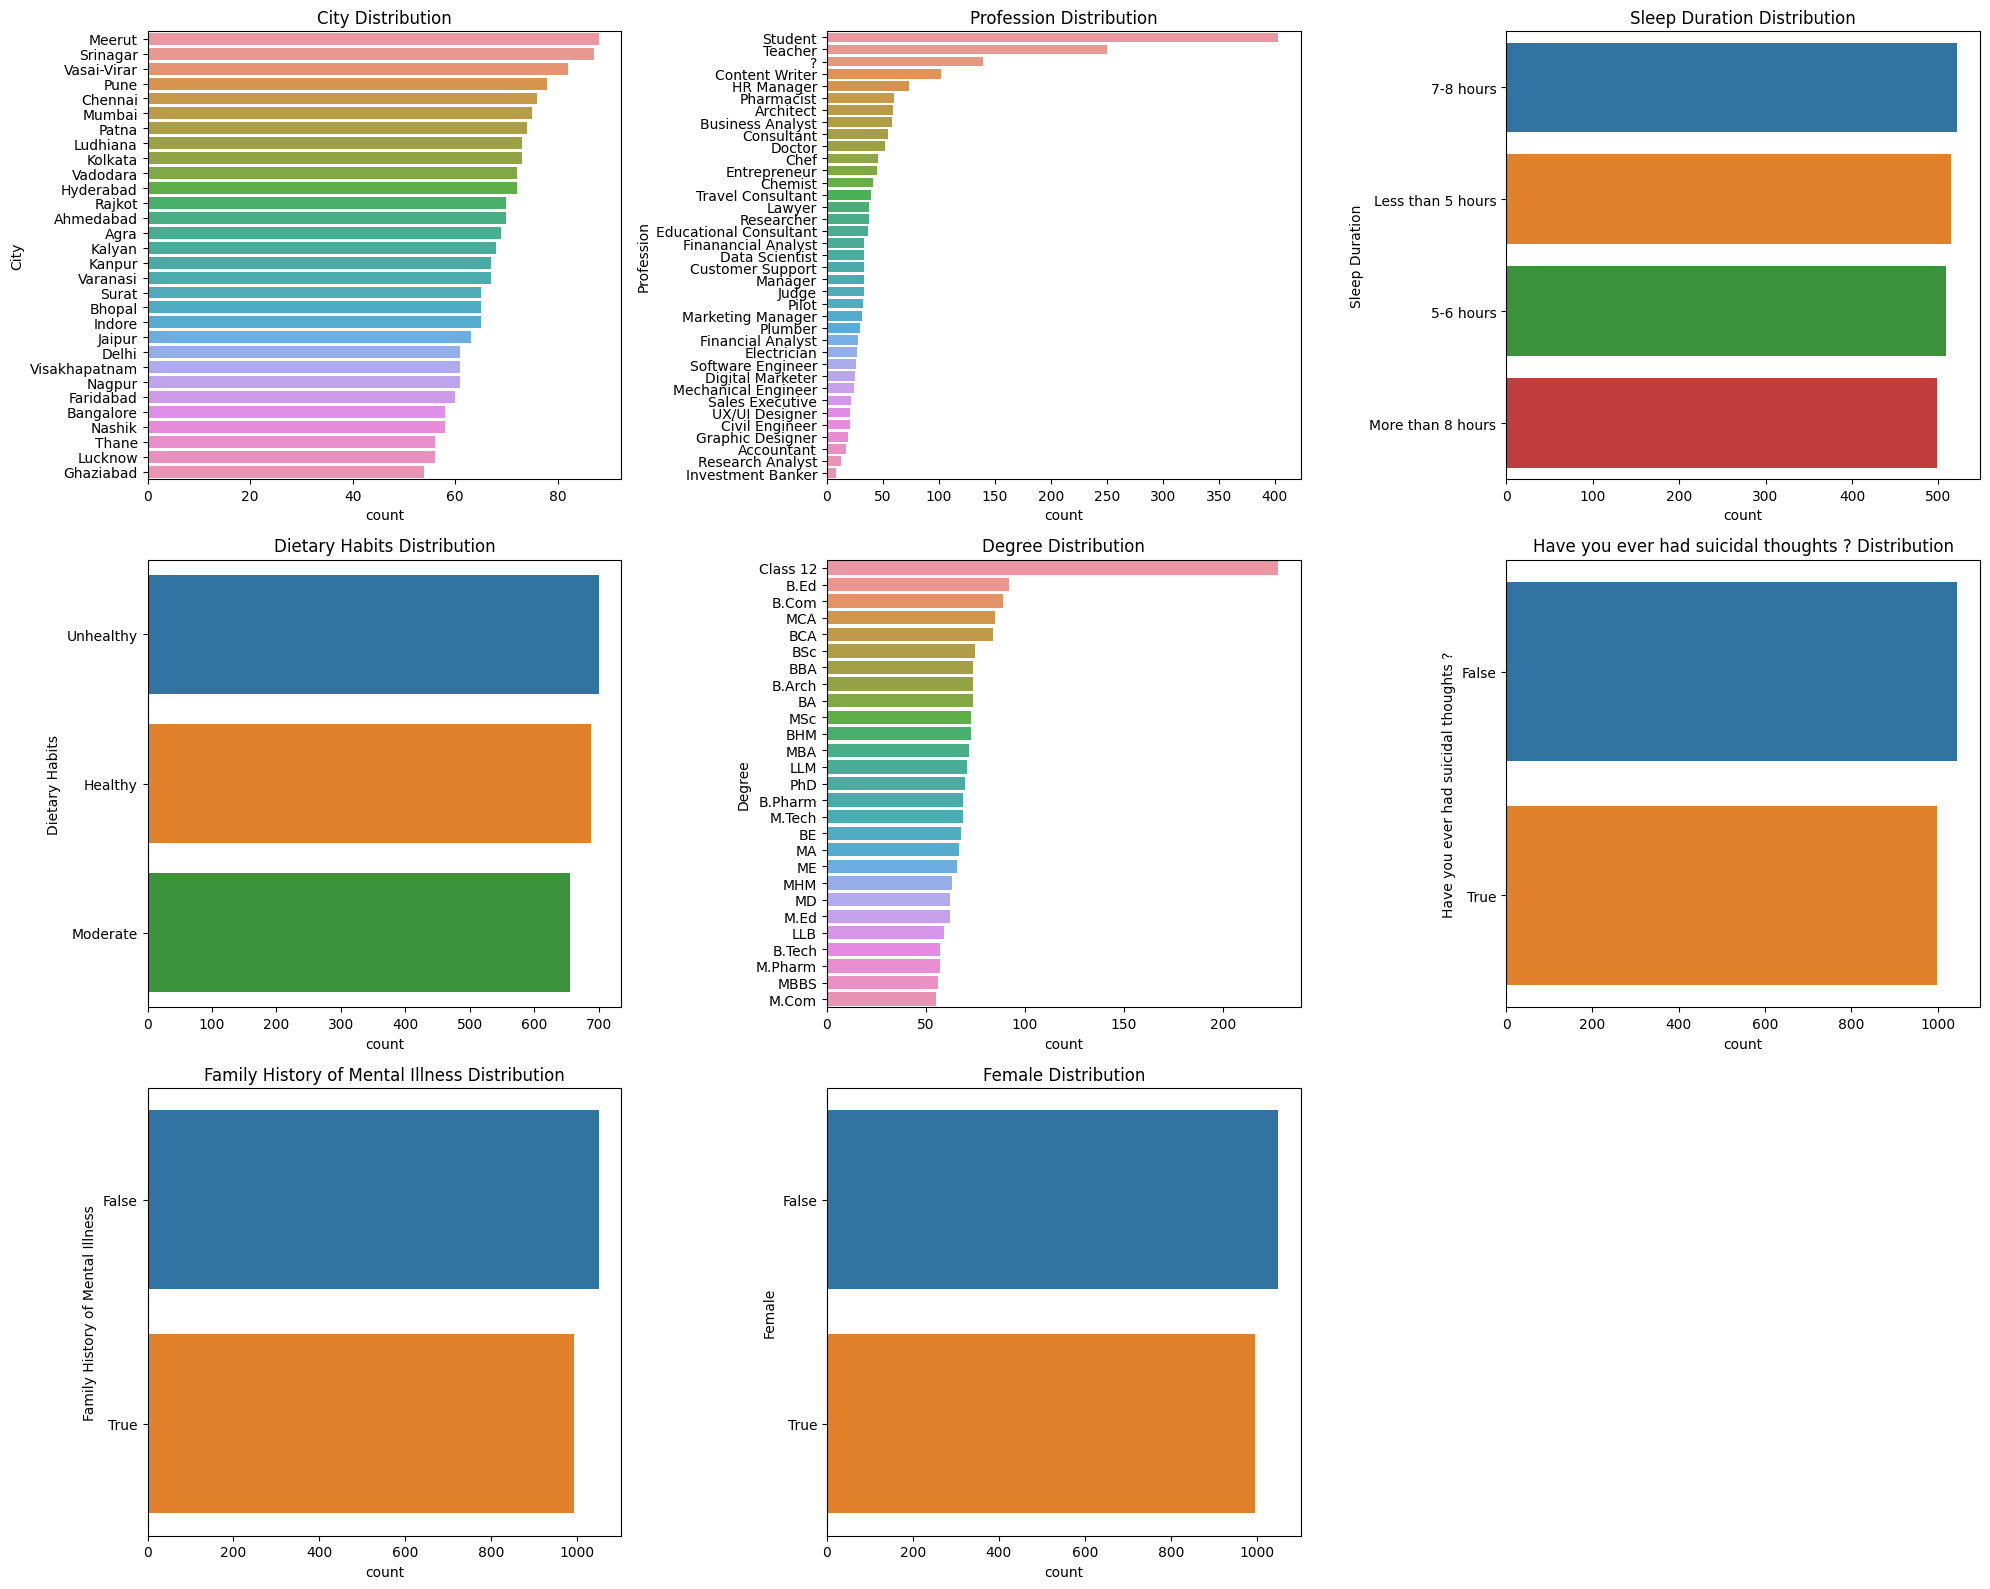

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


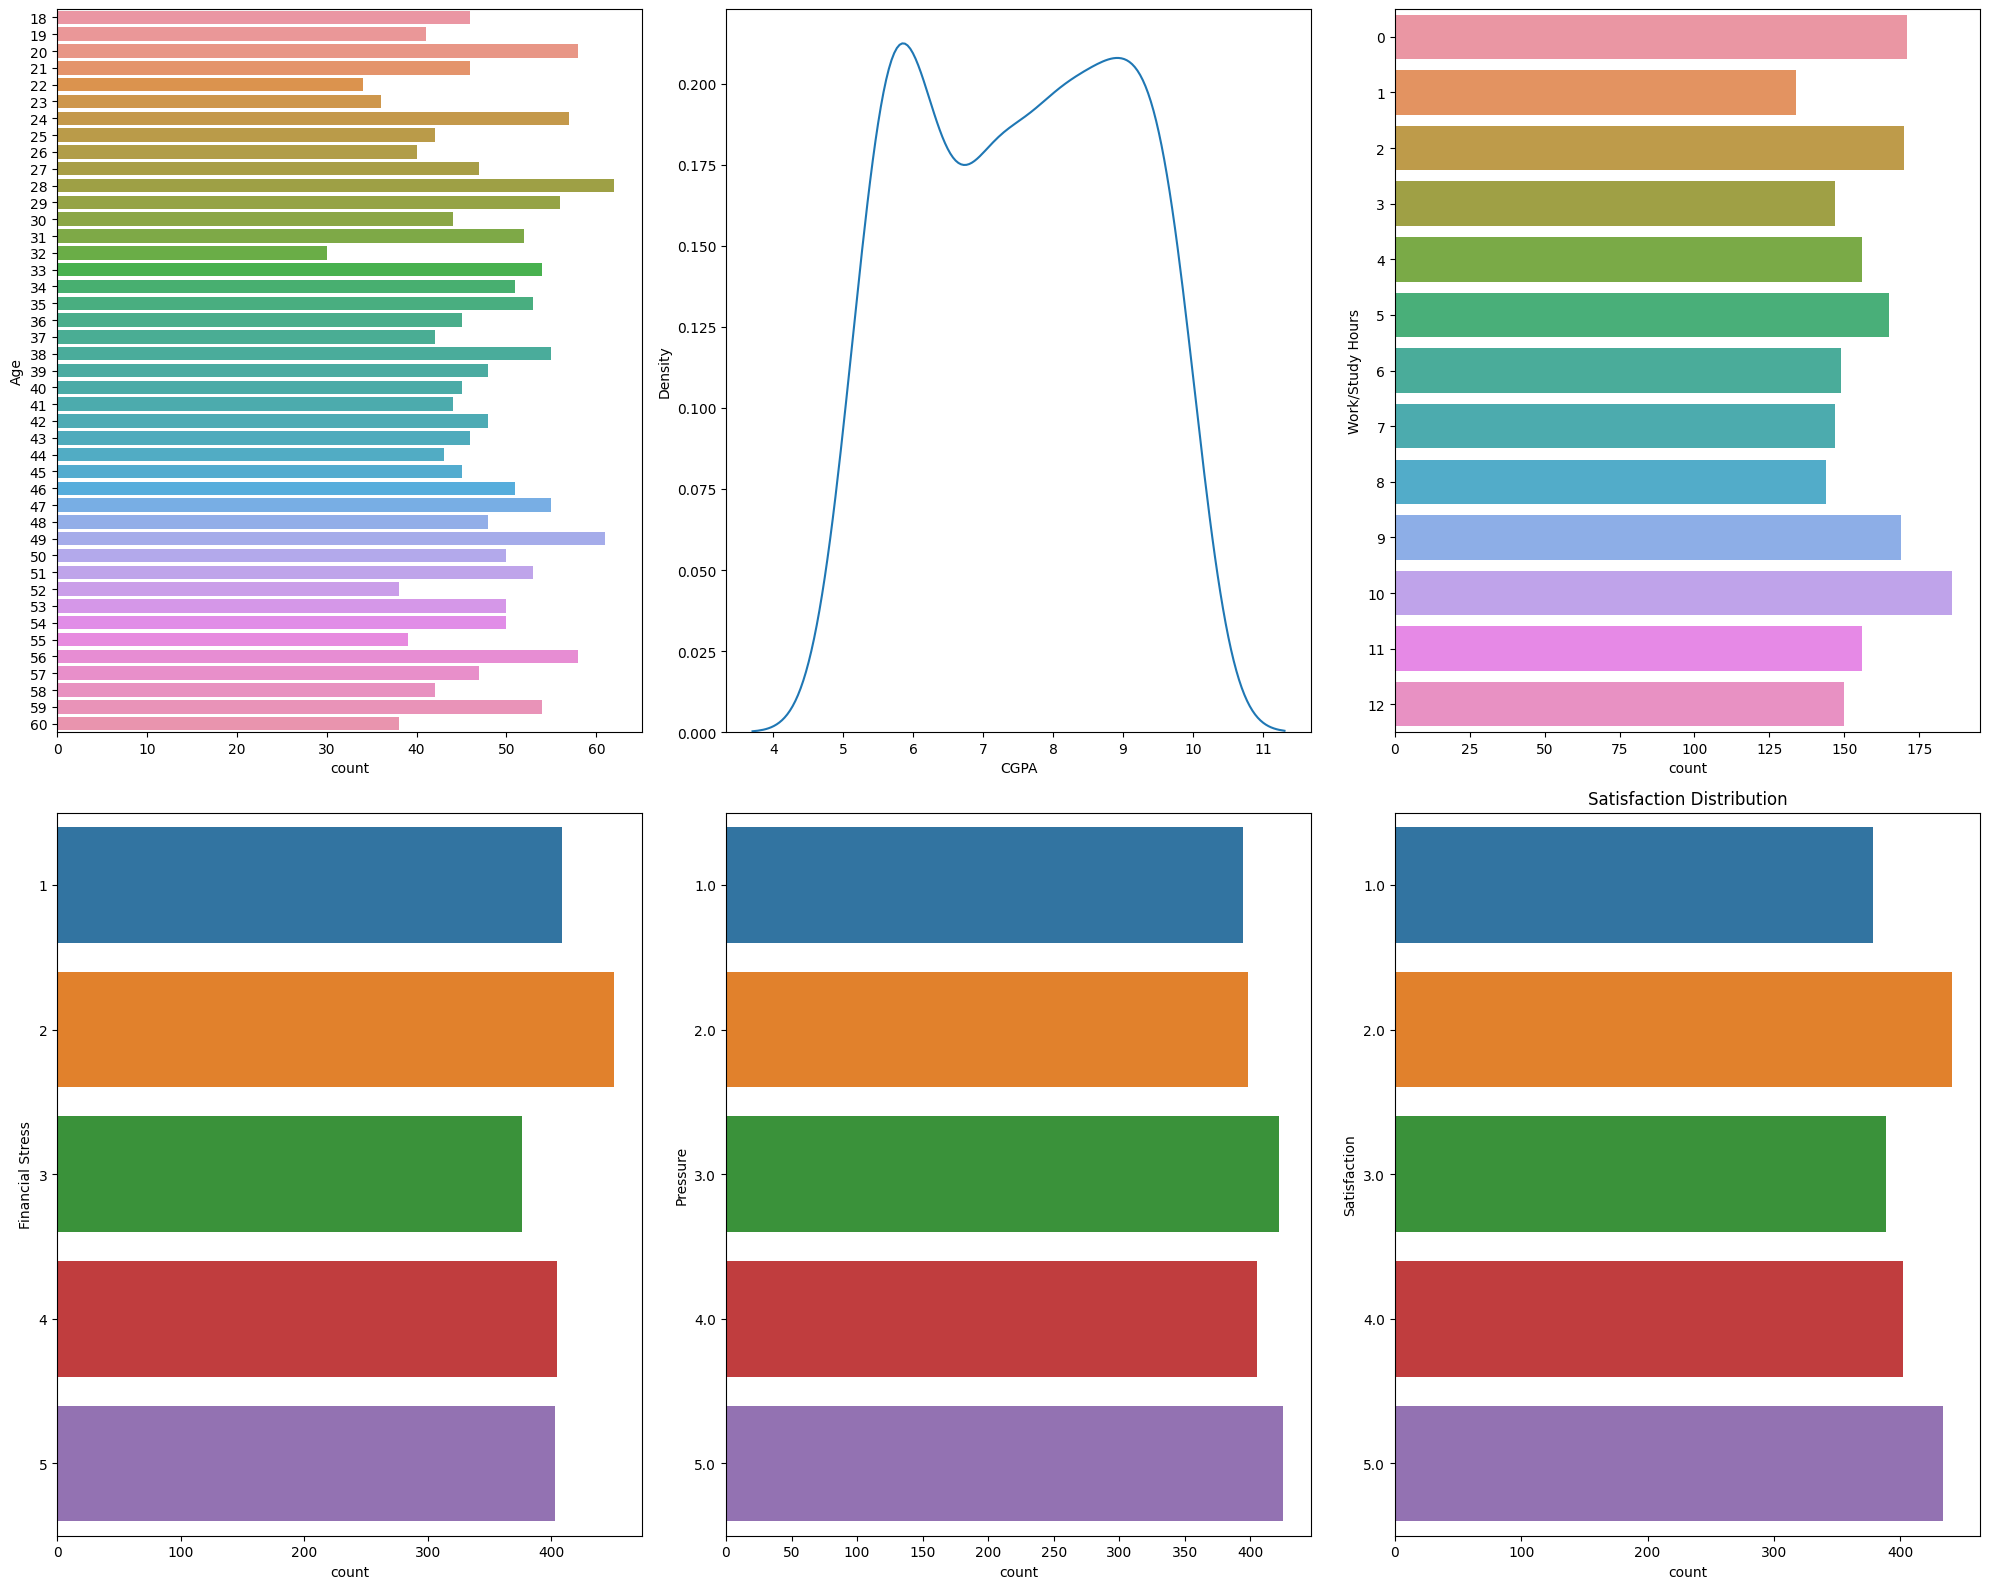

In [20]:
# Create countplots for the categorical features
fig, axes = plt.subplots((len(cat_feats) + 2) // 3, 3, figsize=(20, 16))
axes = axes.flatten()
for ax, col in zip(axes, cat_feats):
    sns.countplot(data=depression_train, y=col, ax=ax, order=depression_train[col].value_counts().index)
    ax.set_title(f"{col} Distribution")
for i in range(len(cat_feats), len(axes)):
    axes[i].axis('off') # Turn off remaining axes so that we don't get axes that are drawn with empty plots
plt.tight_layout()
plt.show()

# Create countplots for the categorical features
# 'CGPA' feature is instead plotted as a kdeplot
fig, axes = plt.subplots((len(num_feats) + 2) // 3, 3, figsize=(20, 16))
axes = axes.flatten()
for ax, col in zip(axes, num_feats):
    if col == 'CGPA':
        sns.kdeplot(depression_train[col], ax=ax)
    else:
        sns.countplot(data=depression_train, y=col, ax=ax)
    plt.title(f"{col} Distribution")
for i in range(len(num_feats), len(axes)):
    axes[i].axis('off') # Turn off remaining axes so that we don't get axes that are drawn with empty plots
plt.tight_layout()
plt.show()

### Imbalanced Features
The features in particular that show significant imbalance are:
- **Profession**
    - It was to be expect that there would be more Students than any other individual category. After that, of the categories include more than 100 instances, a significant number of Teachers are included in the data, followed by '?' (non-Student participants with missing values in 'Profession'), and finally 'Content Writer'.
    - There are also a number of categories with very few instances, and therefore might not be representative of the entirely of that profession in reality.
- **Degree**
    - Compared to all other categories for Degree, the Class 12 degree has significantly more instances. The Class 12 degree is the equivalence of a high school diploma, with the assumption being that those in this category do not have a higher level academic degree.


Features that are highly imbalanced can cause issues like overfitting. We may consider creating an 'Other' group for the less frequent categories.

### Analysis Using Histograms
I will use histograms to see how the target values are distributed for each category. I will plot the categories on the x-axis, and the True to False ratio for Depression on the y-axis, and sort by descending order of ratios. I will also include the value counts in parentheses next to the name of each category for reference. This is for the cases where the ratio seems significant but the number of instances is low that it might not be very meaningful.

These plots will show us the distribution of True to False for Depression for each category. While it can give us an idea on the likelihood of depression for a participant belonging to a certain group, we should keep in mind that the target feature is imbalanced. Therefore, we should be careful of categories with low representation as well as those that are heavily skewed towards one side (in particular, very few Trues) since the models may lean heavily towards the majority classes.

In [21]:
# Return the True to False ratios in the dataset df for each category for feature col
# Sorted by T/F ratio if sort is set to True
def TF_ratios(df, col, sort=True):
    TF_ratio = df.groupby(col)['Depression'].value_counts().unstack().fillna(0)
    TF_ratio['T_to_F'] = TF_ratio[True] / TF_ratio[False]
    counts = df[col].value_counts()
    TF_ratio.index = [f"{name} ({counts[name]})" for name in TF_ratio.index]
    if sort:
        TF_ratio = TF_ratio.sort_values(by='T_to_F', ascending=False)
    return TF_ratio['T_to_F']

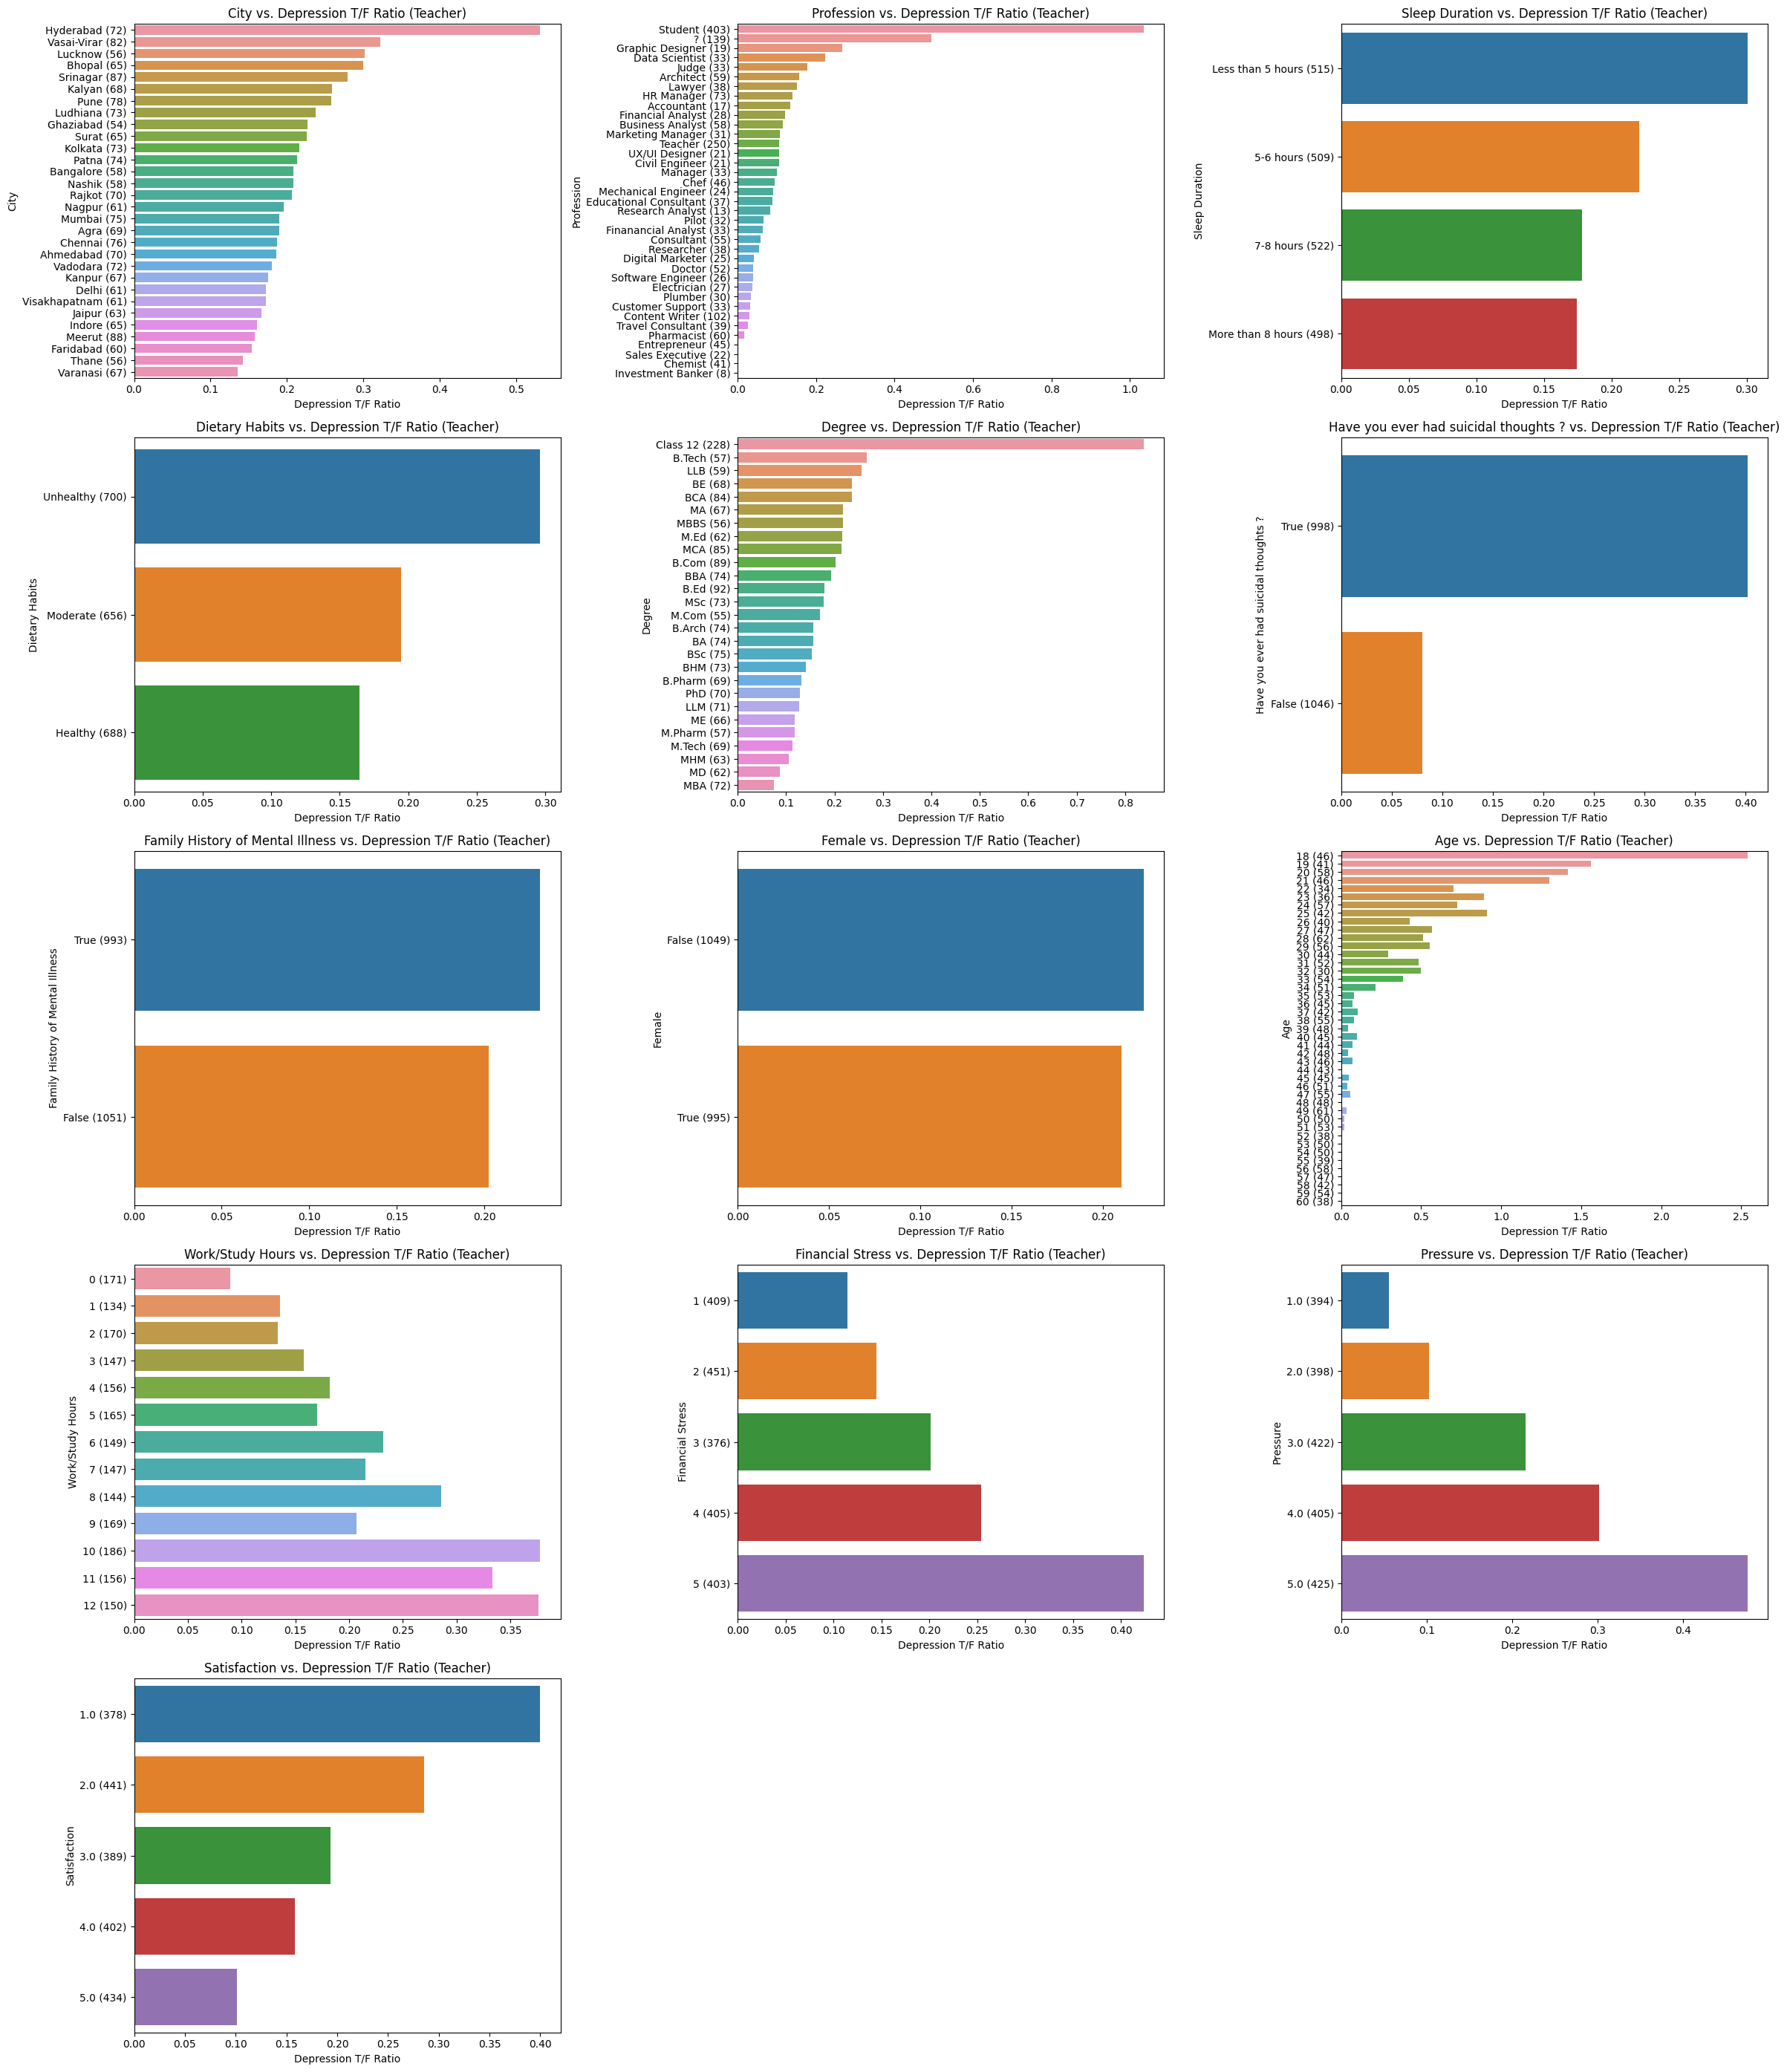

In [22]:
feat_len = len(cat_feats) + len(num_feats) - 1 # Number of features excluding 'CGPA'
fig, axes = plt.subplots((feat_len + 2) // 3, 3, figsize=(24, 28))
axes = axes.flatten()
i = 0 # Index for subplot position
sort = True # Whether or not to sort by T/F ratio

# Create barplots of target T/F ratios for each feature except 'CGPA'
for col in cat_feats + num_feats:
    if col == num_feats[0]:
        sort = False
    if col == 'CGPA':
        continue
    TF_ratio = TF_ratios(depression_train, col, sort=sort)
    sns.barplot(x=TF_ratio, y=TF_ratio.index, ax=axes[i])
    axes[i].set_title(f"{col} vs. Depression T/F Ratio (Teacher)")
    axes[i].set_xlabel('Depression T/F Ratio')
    axes[i].set_ylabel(col)
    i += 1

for i in range(feat_len, len(axes)):
    axes[i].axis('off') # Turn off remaining axes so that we don't get axes that are drawn with empty plots
plt.tight_layout()
plt.show()

For the binary features:
- **Have you ever had suicidal thoughts ?**
    - It's no surprise that the ratio of True to False for Depression is much high for those who have had suicidal thoughts before.
- **Family History of Mental Illness**
    - It seems like those with a family history of mental illness may be slightly more likely to be depressed.
- **Female** (Gender)
    - Their doesn't seem to be a distince difference in the ratio of Depression values between Male and Female. However, we can't rule out the possibility that it may have an interaction effect with another feature.

Looking at the two simpler categorical features Sleep Duration and Dietary Habits:
- **Sleep Duration**
    - Those who sleep more tend to be less likely to be depressed. There doesn't seem to be much of a different between those who sleep 7-8 hours to those who sleep for more than 8 hours, while those who sleep 5-6 hours are somewhat more likely to be depressed, while those who sleep less than 5 hours are significantly more likely to be depressed.
- **Dietary Habits**
    - Those who have healthier dietary habits tend to be less likely to be depressed.
    - Unhealthy has a significantly higher T/F ratio compared to the other two. While the difference between Healthy and Moderate is relatively smaller, there does seem to be a clear difference so I think it's worth keeping the distinction.
- For these two features, I'll simply just use one-hot encoding.

The three remaining features have many categories, so we shouldn't just simply use one-hot encoding since it would result in many additional features, greatly increasing the dimensionality which is inefficient. It would also not suffice to combine categories into specific groupings without a better understanding of the categories, for which consulting a domain expert may be able to help. However, for this project I will just choose individual categories that seem the most meaningful and put the rest into an 'Other' group. One benefit is that this may help generalize better on unseen data, since in reality these features aren't necessarily restricted to the categories in the dataset.
- **Degree**
    - The Class 12 degree has a high T/F ratio of depression of 0.85, although with a high value count relative to the other degrees. The remaining categories range from around 0.07-0.27, although it's hard to say whether they're significantly different from each other at the current sample sizes for each category.
    - Therefore, I decided that it would be best to just create one new binary feature for whether or not they fall under the Class 12 degree.
- **City**
    - This feature is roughly balanced. Hyderabad clearly has a higher True/False Depression ratio compared to each of the other cities, implying that those from this city may be more likely to be depressed.
    - Unlike with the Degree feature, including just one binary feature for Hyderabad doesn't seem to be useful. Including multiple cities as features may provide more insight on how much effect in general that the city one lives in may have on the target. However, including all of them might not be as helpful either, as it would be inefficient and likely overfit. Therefore, I'll choose to include just the cities with a T/F ratio over 0.25 (the top 7 cities with the highest ratios), and put everything else in an 'Other' group before one-hot encoding.
- **Profession**
    - Student clearly has high ratio of 1.0 (roughly equal number of True and False) along with a high number of instances, so we should include it as a binary feature.
    - Aside from 'Student' and '?', there are several professions that might be important such as 'Graphic Designer' which has a relatively high ratio or those with absolutely no depressed individuals such as 'Investment Banker' or 'Chemist'.
        - However, we notice that many of these professions have relatively low counts, which would mean that the values may vary more greatly. Therefore, we will put them into an 'Other' group.
        - 'Teacher' and 'Content Writer' each have counts of over 100 (250 and 102) so they are less likely the suffer the aforementioned issue. However, 'Content Writer' has a low T/F ratio which could suggest that Content Writers are less likely to be depressed relative to other Profession but at the same time may not be suited as a predictor because it may be prone to overfit so I'll put it in 'Other'. Teacher, on the other hand, has more instances although the T/F ratio seems to be around the mean for the ratios of the non-Students. I'll do some further analysis on the 'Teacher' category to see if there is an interaction with other features.
    - Those in the '?' category (where the value was originally null) seem to have a significantly higher T/F ratio compared to other Professions aside from Student in addition to having a relatively high frequency of 139. We will also look into this group to see if we can put it in 'Other' or if it should remain distinct.

The integer numerical features all seem to have some correlation with the target.
- 'Age' seems to have a somewhat negatively exponential relationship with the likelihood of depression, so it may not a good idea to bin the ages since even a couple years difference in age may be important especially for lower ages. It would be best to keep it as a numerical feature.
- 'Work/Study Hours' generally seems positively correlated to Depression. While I don't fully understand what the numbers represent (it might be a mistranslation or there might be some cultural reason or maybe something else), it doesn't seem to be an error as each value has well over 100 instances. We should keep this feature for building out models for predictions. Although it would be important to understand what this feature exactly represents when it comes to explainability of results.

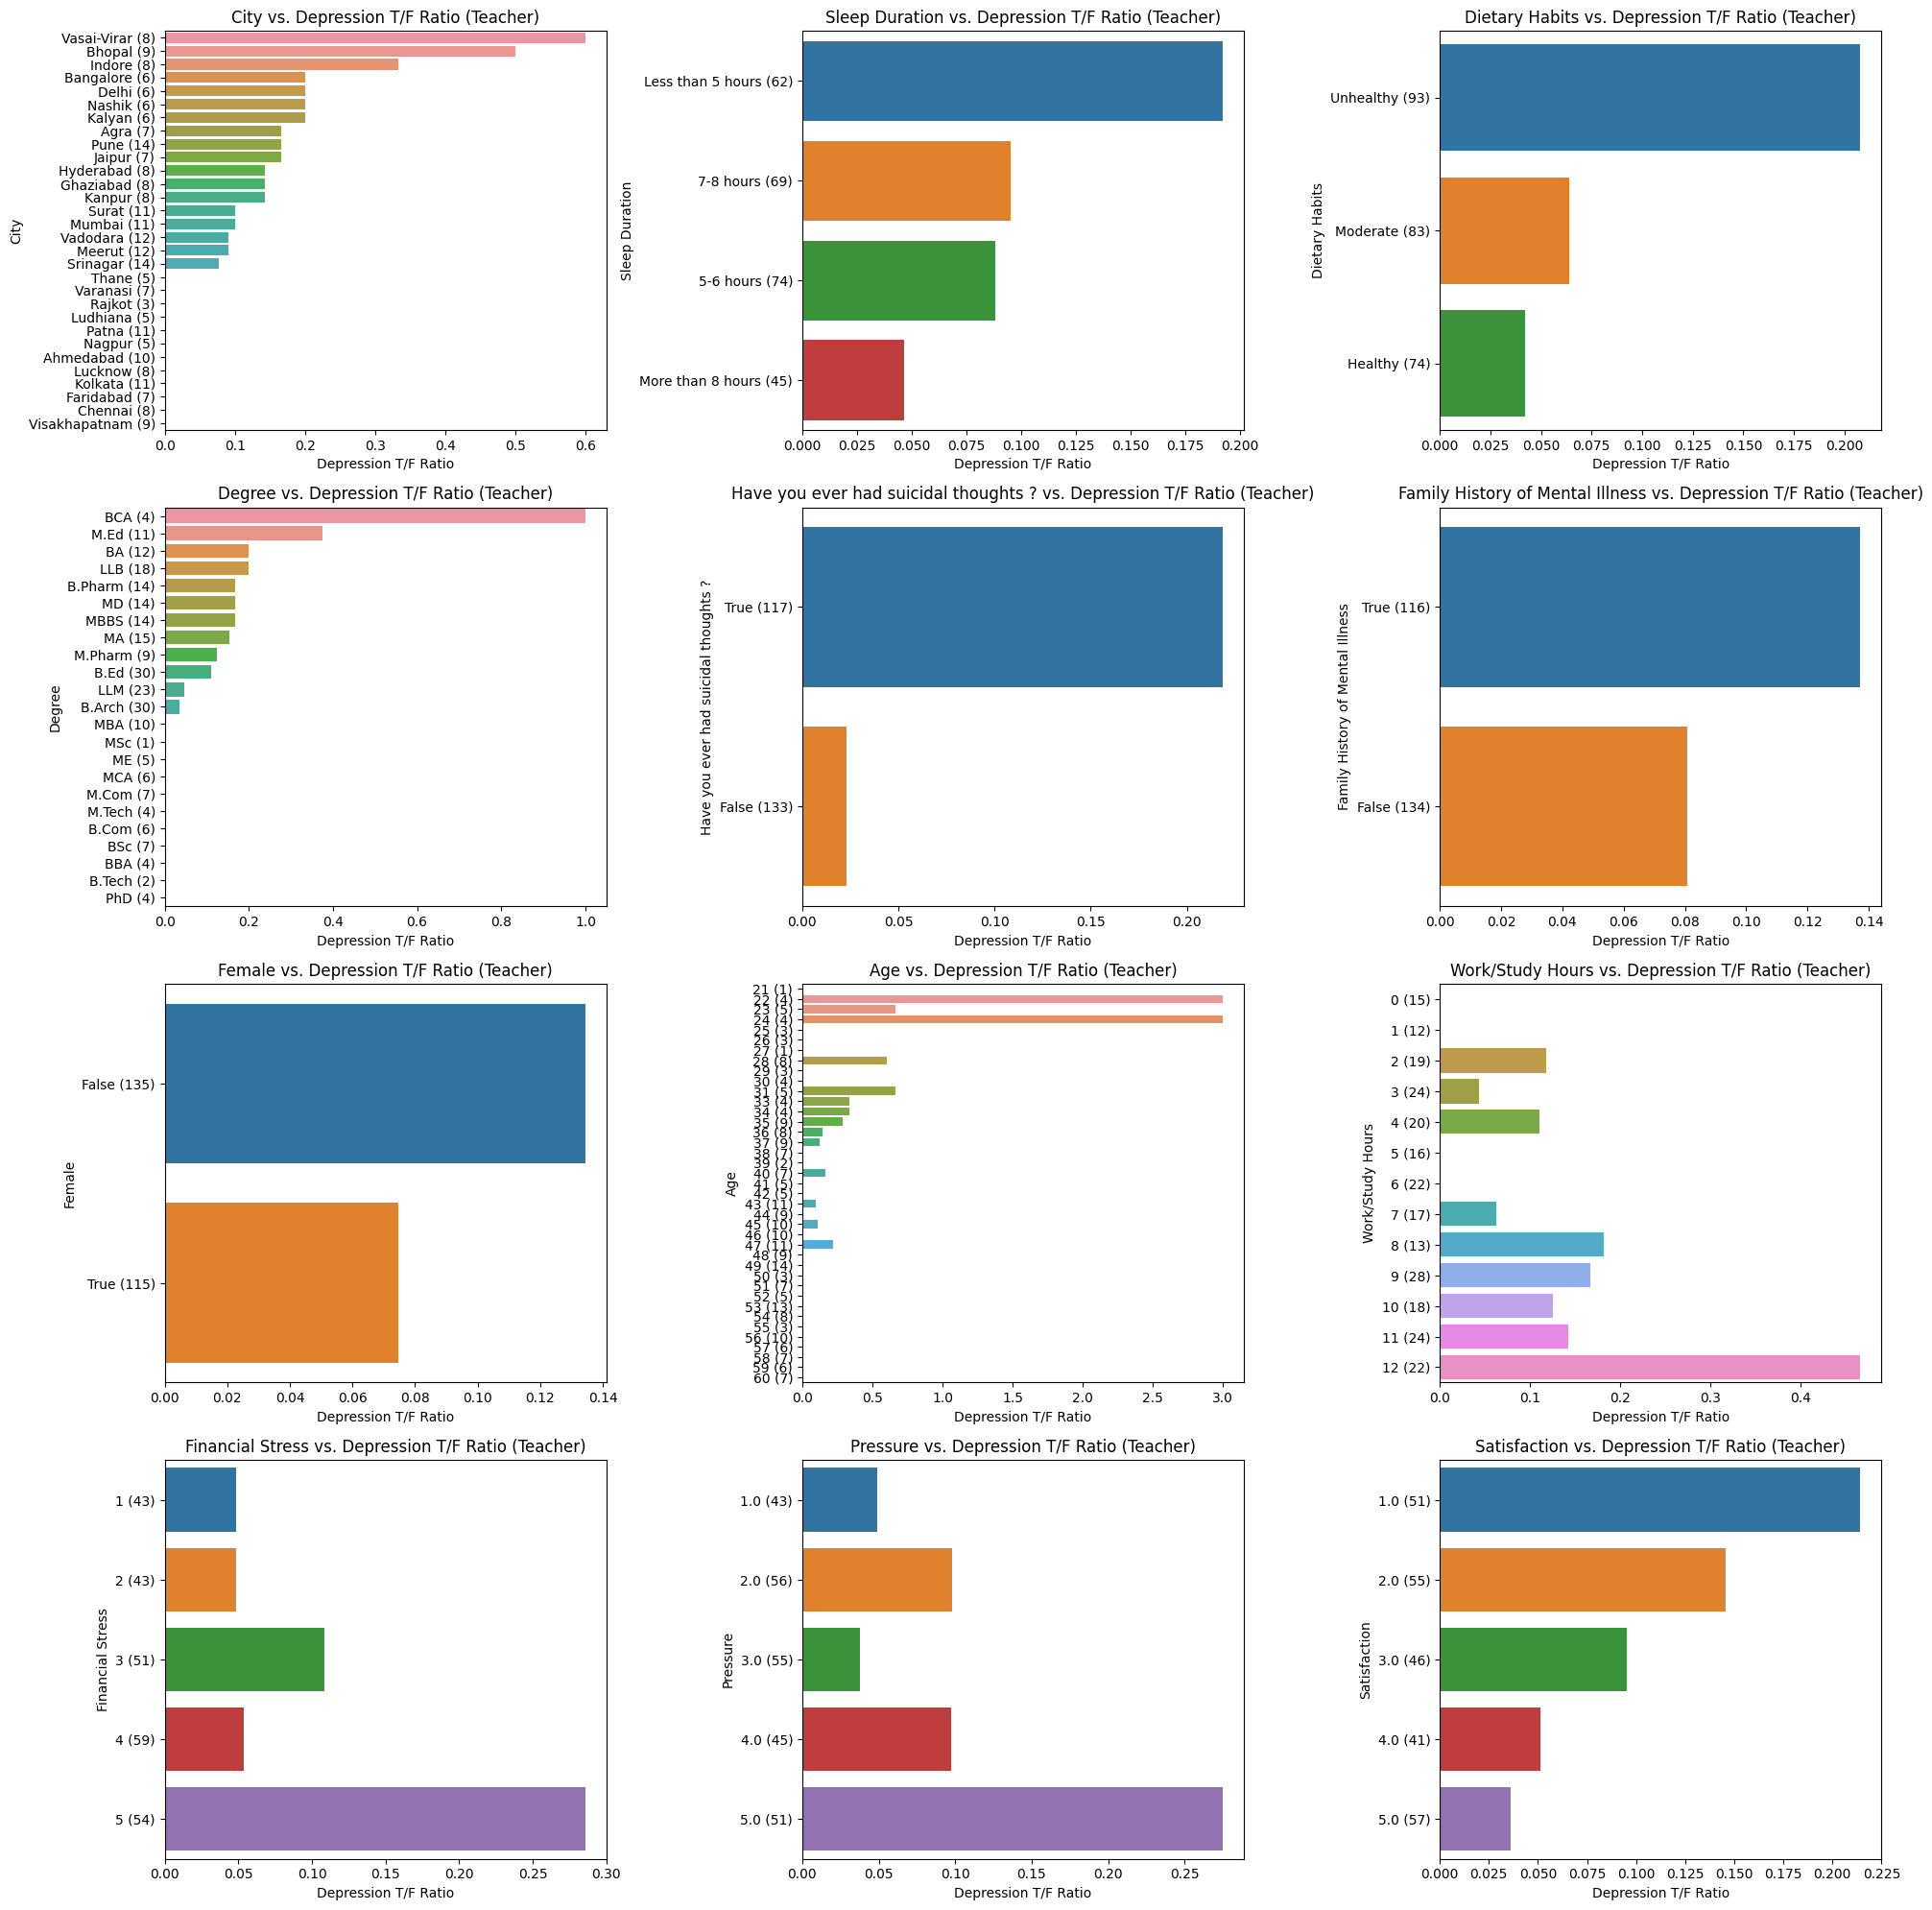

In [23]:
# Get data for just Teachers
depression_teachers = depression_train[depression_train['Profession'] == 'Teacher']

feat_len = len(cat_feats) + len(num_feats) - 2 # Number of features excluding 'Profession' and 'CGPA'
fig, axes = plt.subplots((feat_len + 2) // 3, 3, figsize=(20, 20)) 
axes = axes.flatten()
i = 0 # Index for subplot position
sort = True # Whether or not to sort by T/F ratio

# For instances in the 'Teacher' category of 'Profession',
# create barplots of target T/F ratios for every other feature except 'Profession' and 'CGPA'
for col in cat_feats + num_feats:
    if col == num_feats[0]:
        sort = False # For int numerical features, we leave in the original order
    if col in ['Profession', 'CGPA']:
        continue
    TF_ratio = TF_ratios(depression_teachers, col, sort=sort)
    sns.barplot(x=TF_ratio, y=TF_ratio.index, ax=axes[i])
    axes[i].set_title(f"{col} vs. Depression T/F Ratio (Teacher)")
    axes[i].set_xlabel('Depression T/F Ratio')
    axes[i].set_ylabel(col)
    i += 1

for i in range(feat_len, len(axes)):
    axes[i].axis('off') # Turn off remaining axes so that we don't get axes that are drawn with empty plots
plt.tight_layout()
plt.show()

### Analysis of 'Teachers' category

The trends seem to be similar to that of the overall dataset. While there do seem to be larger different between some of the bars in the plots, this is due to larger variance in values because of smaller sample sizes and/or the x-axis is scaled to smaller increments making the difference visually larger than it actually is. The plots for 'Financial Stress' and 'Pressure' seem interesting but isn't enough to say for confidence that there an interaction between these features and the 'Teacher' category. To avoid overfitting to the training set, we'll put Teacher's in the 'Other' category.

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:645: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  g_vals = grouped_vals.get_group(g)


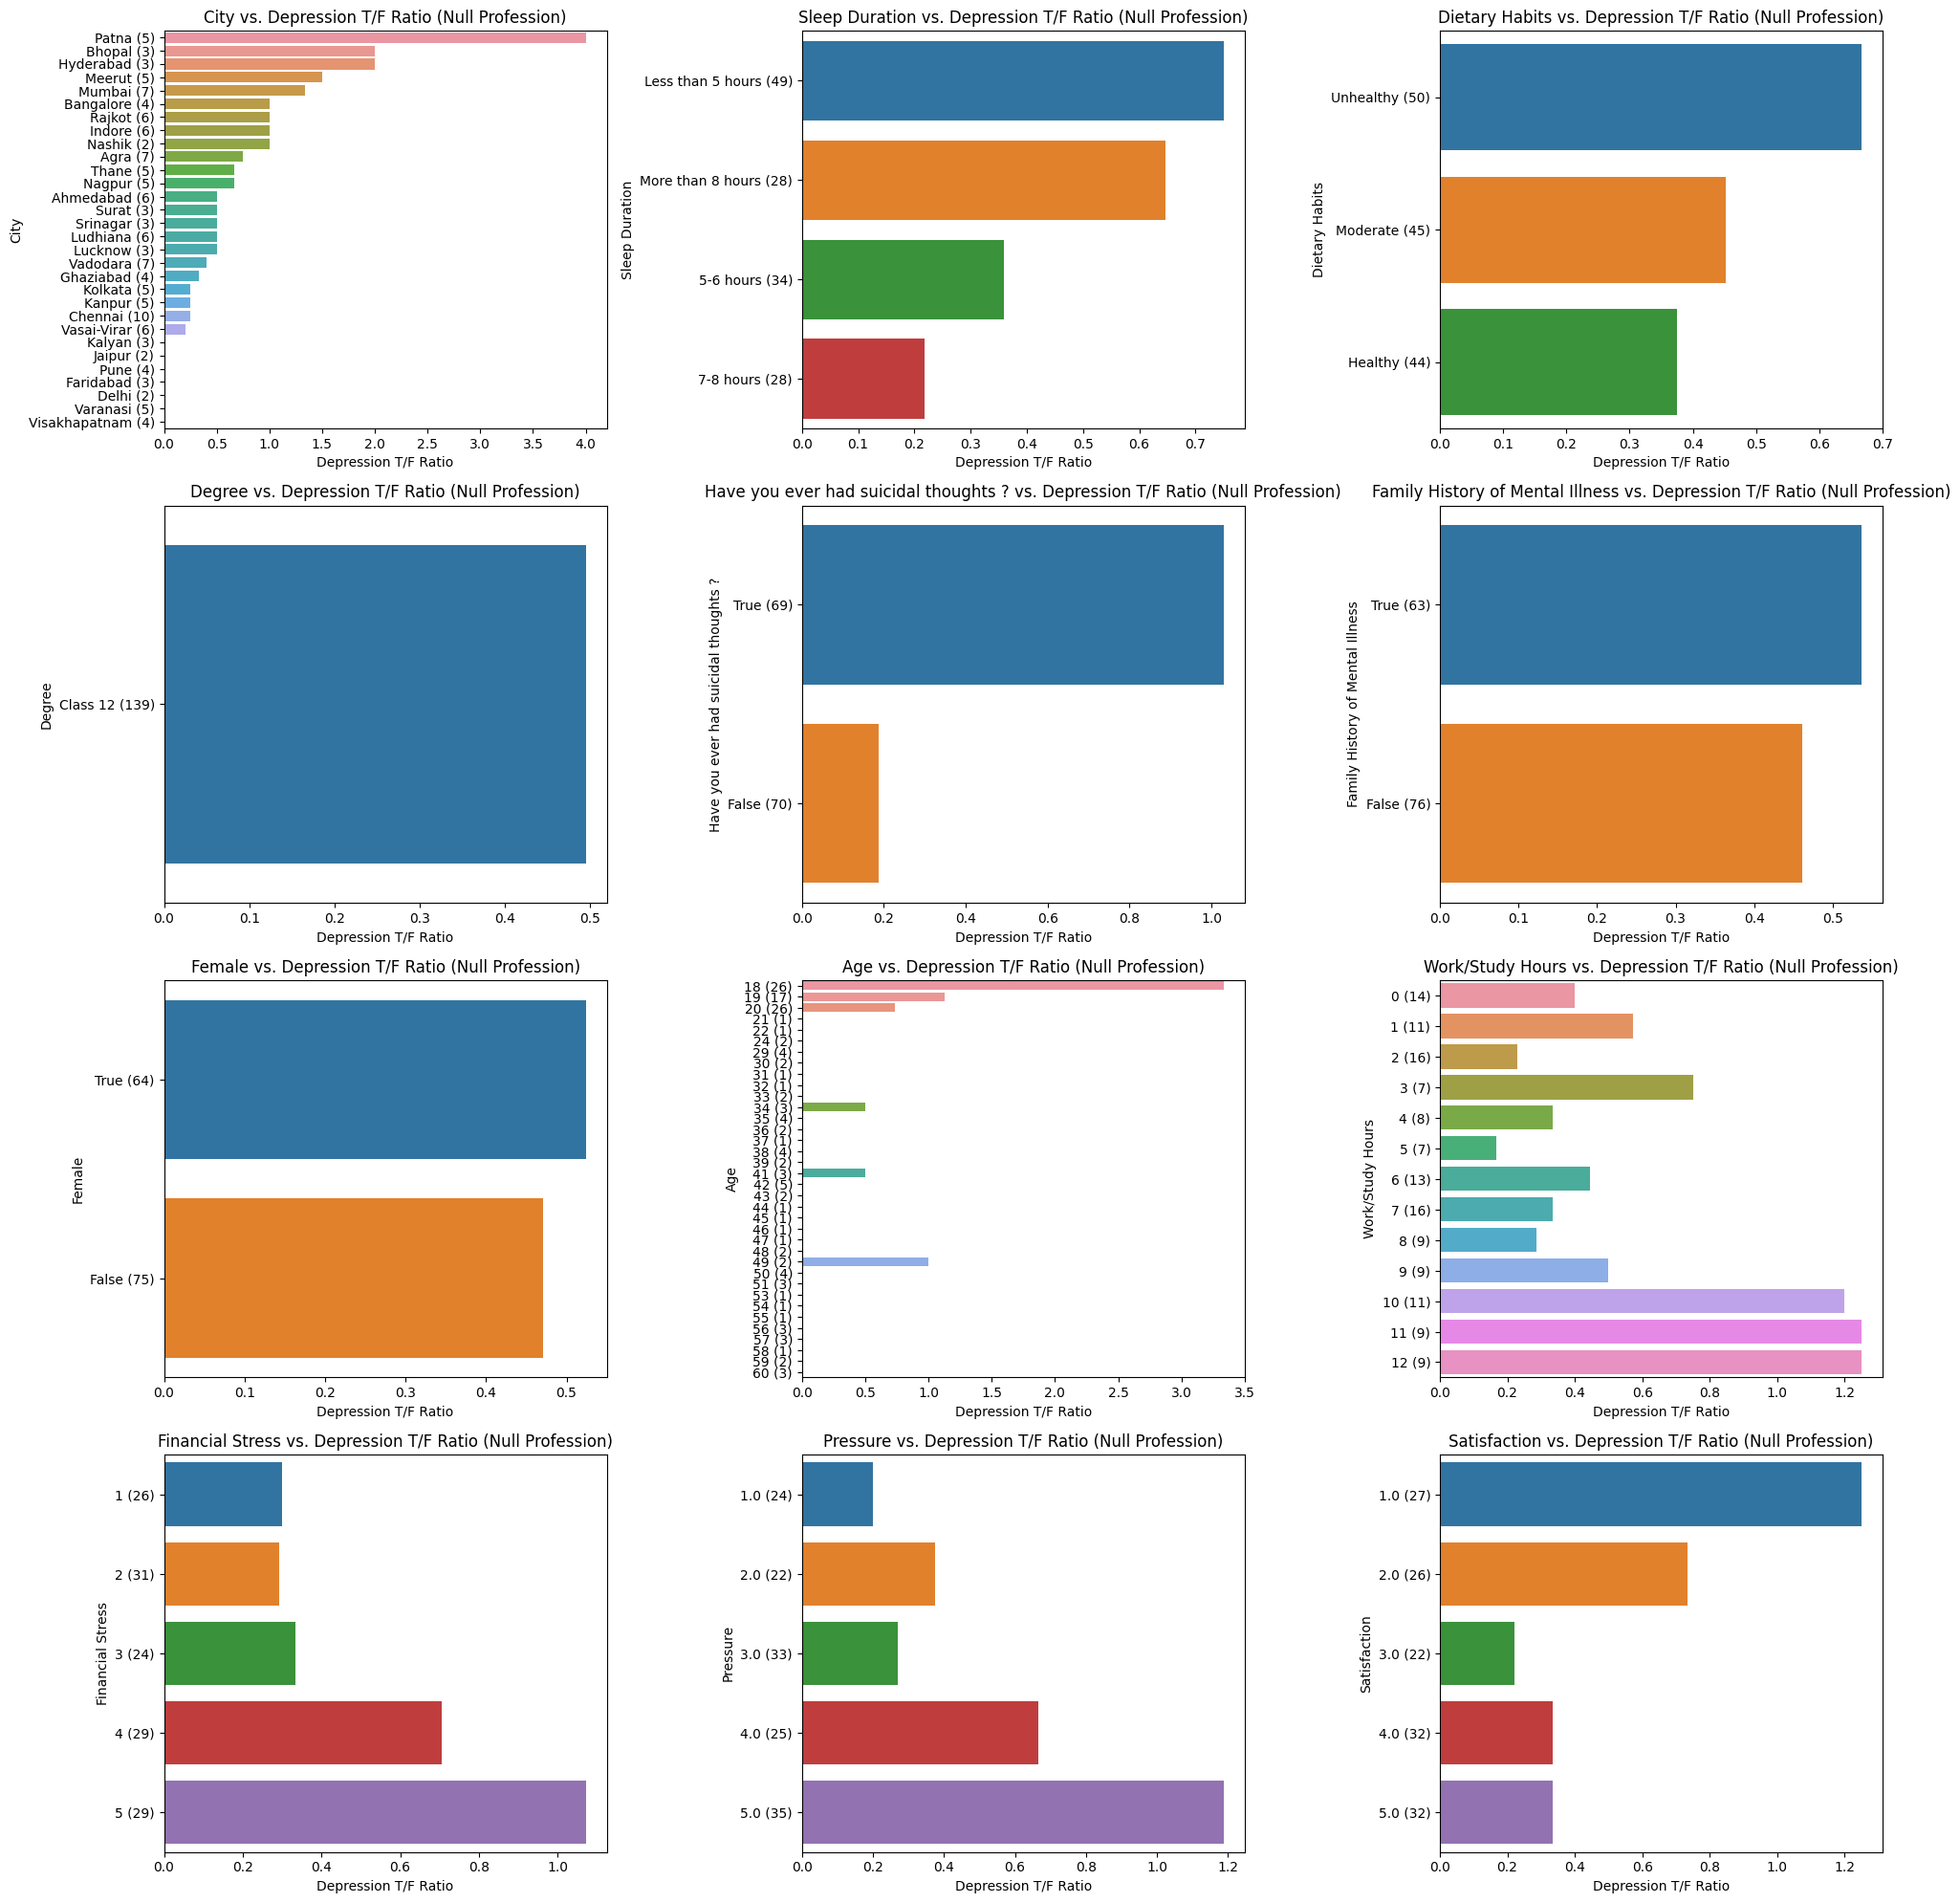

In [24]:
# Get data for just '?' in Profession
depression_null = depression_train[depression_train['Profession'] == '?']

feat_len = len(cat_feats) + len(num_feats) - 2 # Number of features excluding 'Profession' and 'CGPA'
fig, axes = plt.subplots((feat_len + 2) // 3, 3, figsize=(20, 20))
axes = axes.flatten()
i = 0 # Index for subplot position
sort = True # Whether or not to sort by T/F ratio

# For instances in the '?' category (originally null) of 'Profession',
# create barplots of target T/F ratios for every other feature except 'Profession' and 'CGPA'
for col in cat_feats + num_feats:
    if col == num_feats[0]:
        sort = False # For int numerical features, we leave in the original order
    if col in ['Profession', 'CGPA']:
        continue
    TF_ratio = TF_ratios(depression_null, col, sort=sort)
    sns.barplot(x=TF_ratio, y=TF_ratio.index, ax=axes[i])
    axes[i].set_title(f"{col} vs. Depression T/F Ratio (Null Profession)")
    axes[i].set_xlabel('Depression T/F Ratio')
    axes[i].set_ylabel(col)
    i += 1
    
for i in range(feat_len, len(axes)):
    axes[i].axis('off') # Turn off remaining axes so that we don't get axes that are drawn with empty plots
plt.tight_layout()
plt.show()

### Analysis of Null Values in Profession feature

If we look at the frequencies of each category, we see that most of the null values in Profession are from 18-20 year olds and all are from the Class 12 Degree category. As we saw earlier, these indicate a higher likelihood of depression. This explains the relatively higher likelihood of depression in the '?' group compared to non-Student professions, which is likely a result of an interaction between 'Age' and 'Degree'. Perhaps this group represents those who didn't pursue a higher education and/or have a job that doesn't require specialized education or skills, and possibly might even include those who are unemployed. However, this is just speculation.

There are a handful of older individuals included in this group for whom the ratio of True to False is high when compared to the overall dataset. However, since there are only a few of these instances, it may not generalize well.

Therefore, it might be best just to put it with the 'Other' group. In the end, from the 'Profession' feature, we end up with only a single binary feature representing 'Student' (which ended up just being equivalent to the original feature 'Working Professional or Student').

### Analysis of 'CGPA' feature

Let's now look at the 'CGPA' feature, which only has non-null values for Students. Since about 80% of the dataset contains null values for CGPA, simply imputing a value (such as the mean) may lead to more bias. However, I would like to at least look into the possibility of CGPA being a good predictor for depression in Students.

<ipython-input-25-f5eeee3de594>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  depression_student['Only Class 12 Degree'] = depression_student['Degree'] == 'Class 12'


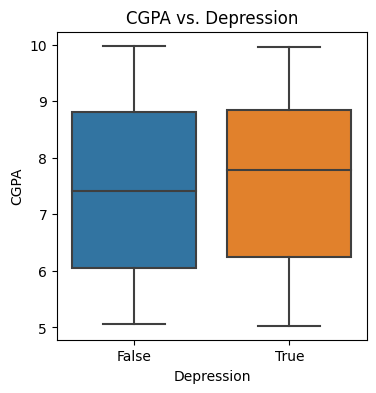

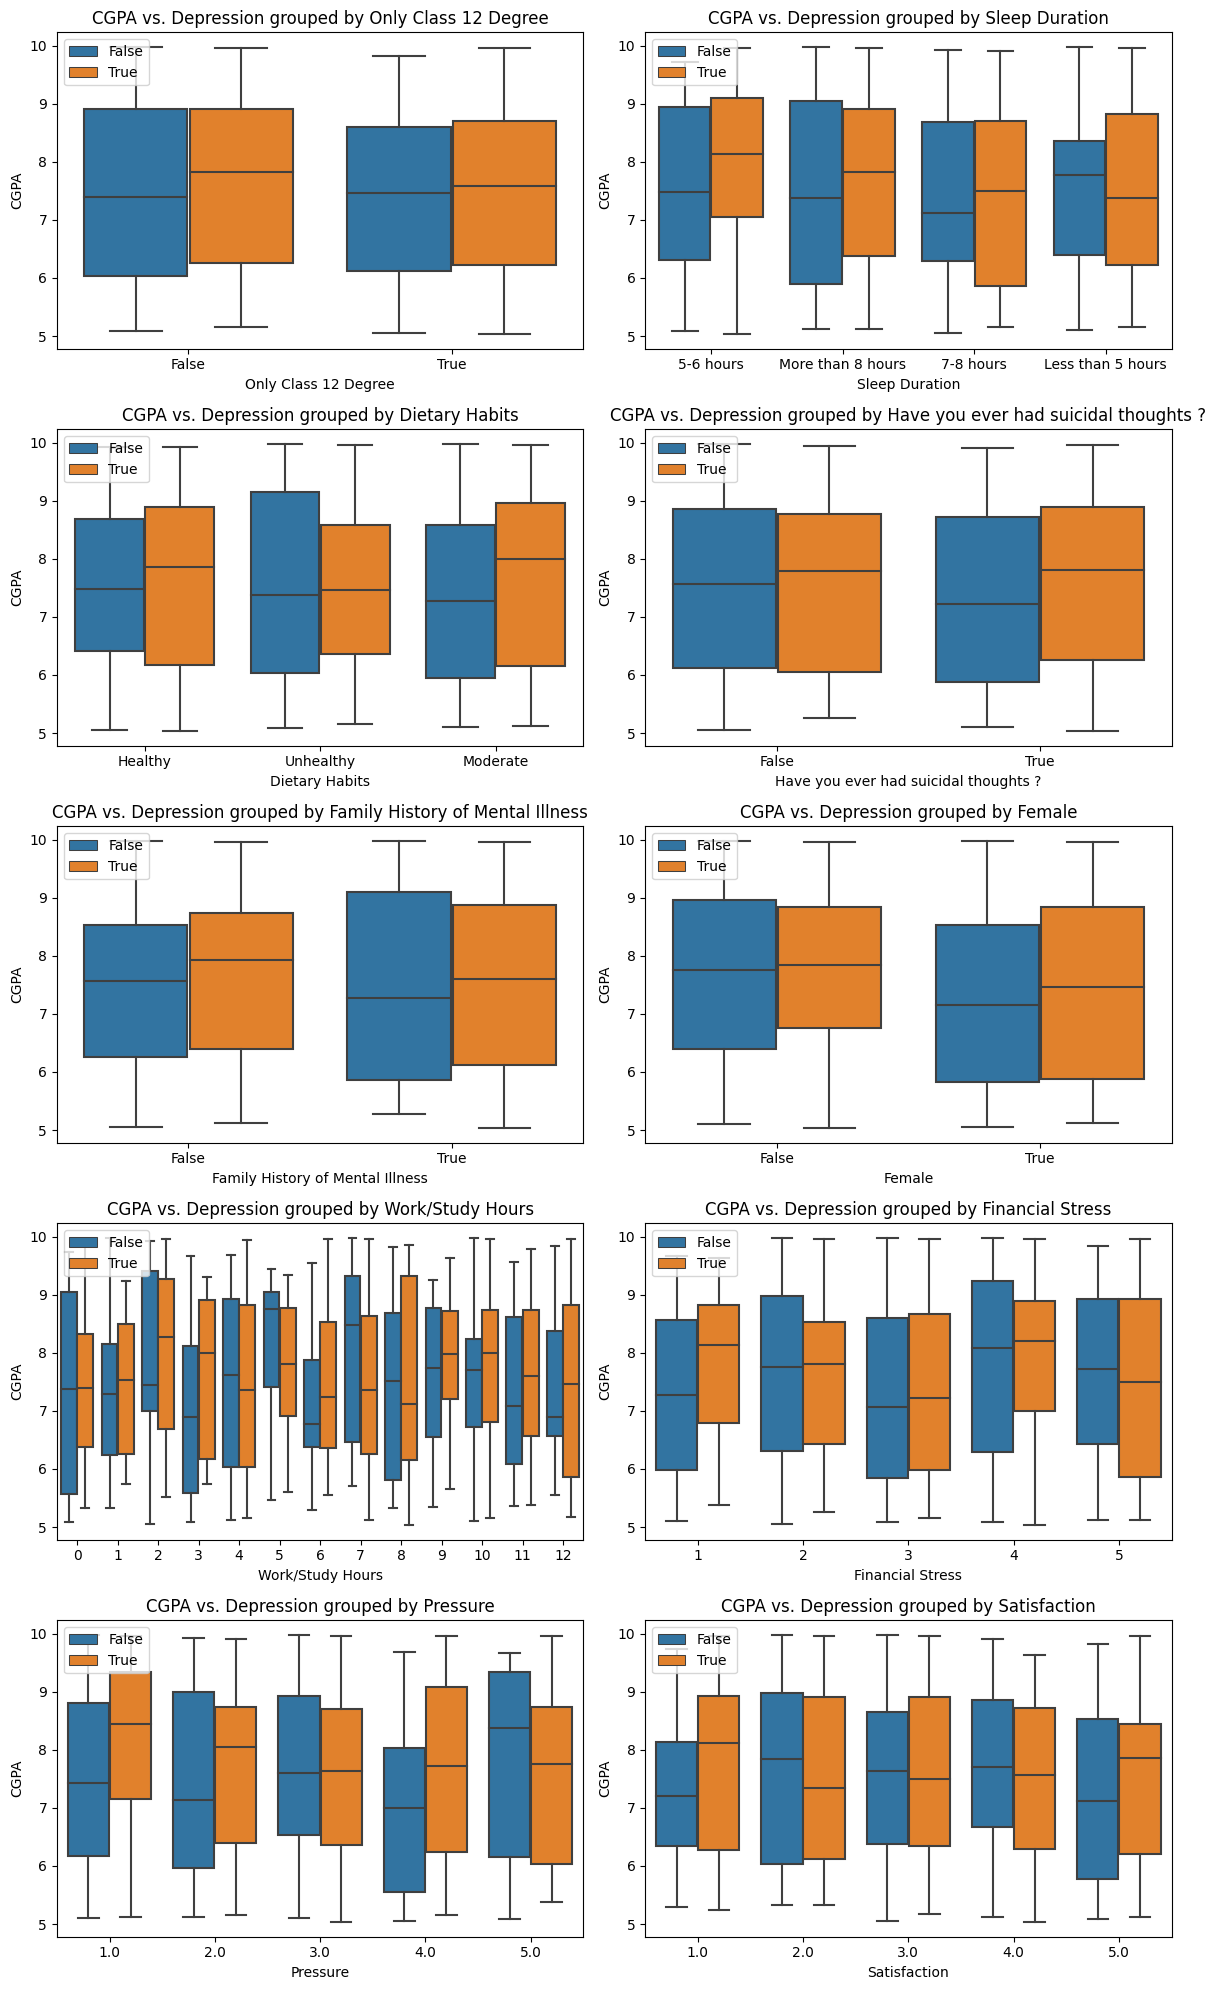

In [25]:
depression_student = depression_train[depression_train['Profession'] == 'Student']
depression_student['Only Class 12 Degree'] = depression_student['Degree'] == 'Class 12'

# Boxplot for CGPA vs. Depression
plt.figure(figsize=(4, 4))
sns.boxplot(data=depression_student, x='Depression', y='CGPA')
plt.title("CGPA vs. Depression")
plt.show()

# Features to group by for boxplots
cols = ['Only Class 12 Degree', 'Sleep Duration', 'Dietary Habits', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Female', 'Work/Study Hours', 'Financial Stress', 'Pressure', 'Satisfaction']

# Boxplot for CGPA vs. Depression grouped by other features
fig, axes = plt.subplots((len(cols) + 1) // 2, 2, figsize=(12, 20))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    sns.boxplot(data=depression_student, x=col, y='CGPA', hue='Depression', ax=ax)
    ax.set_title(f"CGPA vs. Depression grouped by {col}")
    ax.legend(loc='upper left')
    
for i in range(len(cols), len(axes)):
    axes[i].axis('off')
plt.tight_layout()
plt.show()

There doesn't seem to be much correlation between CGPA and Depression, even when we pair it with other features (I left out cities and age since there likely isn't an interaction between them and CGPA). So, it looks like we can simply drop the CGPA feature.

### Data Encoding

In [26]:
depression_processed = depression_train.copy()

# Create 'Student' and 'Only Class 12 Degree' features
depression_processed['Student'] = depression_train['Profession'] == 'Student'
depression_processed['Only Class 12 Degree'] = depression_train['Degree'] == 'Class 12'

# For 'City' feature, grouped certain cities in 'Other'
cities = ['Hyderabad', 'Vasai-Virar', 'Lucknow', 'Bhopal', 'Srinagar', 'Kalyan', 'Pune']
depression_processed['City'] = np.where(depression_train['City'].isin(cities), depression_train['City'], 'Other')
cities = ['Other'] + cities

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Create One-Hot Encoder for City
city_encoder = OneHotEncoder(categories=[cities], drop='first', sparse=False, handle_unknown='ignore')

# Create a column transformer for the different encoders
ct = ColumnTransformer(
    transformers=[
        ('sleep', OneHotEncoder(), ['Sleep Duration']),
        ('diet', OneHotEncoder(), ['Dietary Habits']),
        ('city', city_encoder, ['City']),
    ],
    verbose_feature_names_out=False
)

depression_encoded = pd.DataFrame(ct.fit_transform(depression_processed), columns=ct.get_feature_names_out())
depression_encoded.index = depression_processed.index

for col in depression_encoded.columns:
    depression_processed[col] = depression_encoded[col]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
# Remove unneeded features
depression_processed = depression_processed.select_dtypes(exclude=['object']).drop(['CGPA'], axis=1)

# Move 'Depression' to the last column position
depression_processed['Depression'] = depression_processed.pop('Depression')
depression_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2044 entries, 1665 to 27
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    2044 non-null   int64  
 1   Have you ever had suicidal thoughts ?  2044 non-null   bool   
 2   Work/Study Hours                       2044 non-null   int64  
 3   Financial Stress                       2044 non-null   int64  
 4   Family History of Mental Illness       2044 non-null   bool   
 5   Pressure                               2044 non-null   float64
 6   Satisfaction                           2044 non-null   float64
 7   Female                                 2044 non-null   bool   
 8   Student                                2044 non-null   bool   
 9   Only Class 12 Degree                   2044 non-null   bool   
 10  Sleep Duration_5-6 hours               2044 non-null   float64
 11  Sleep Du

### Correlation Matrix Heatmap

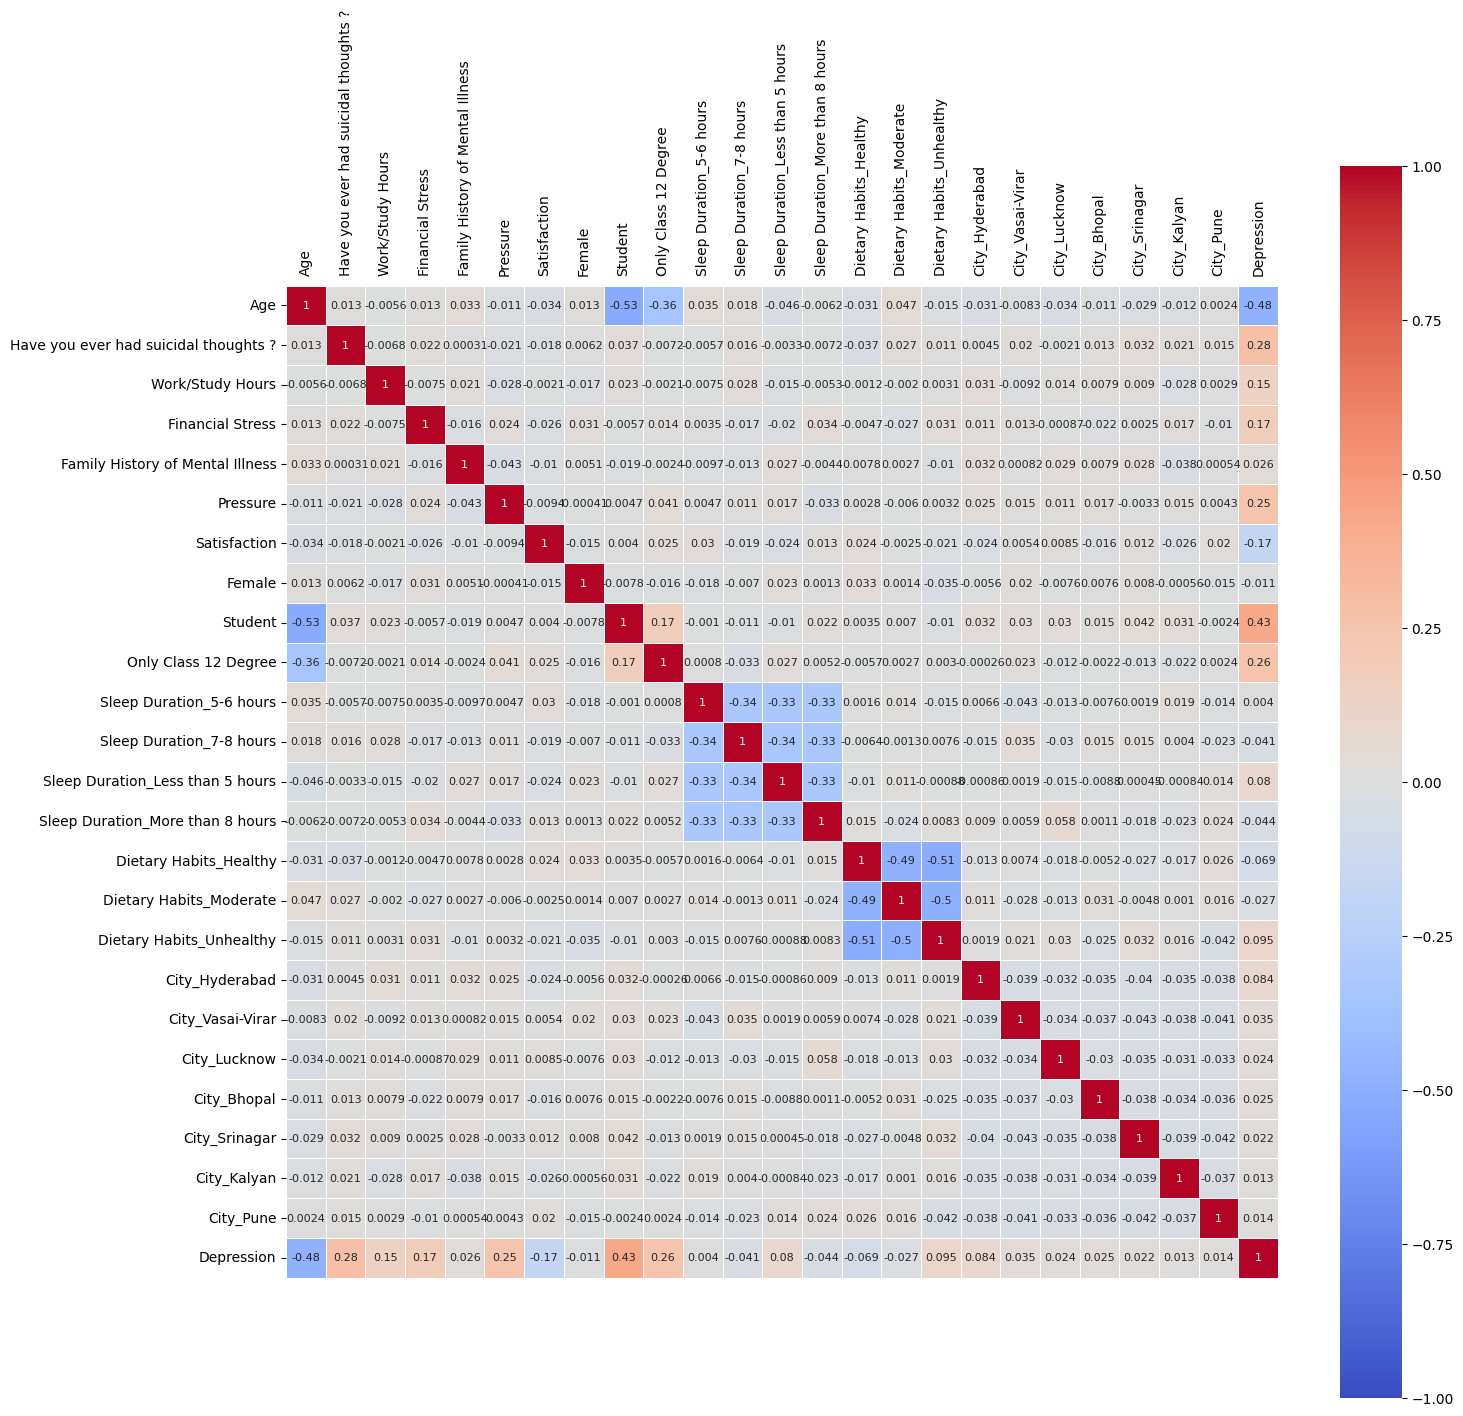

In [29]:
# Display heatmap of correlation matrix of the processed data
plt.figure(figsize=(16, 16))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)
heatmap = sns.heatmap(depression_processed.corr(), vmin=-1, vmax=1, annot=True, annot_kws={"fontsize":8}, linewidth=.5, square=True, cmap="coolwarm")

In [30]:
# Sort correlation coefficients between 'Depression' and other variables
depression_processed.corr()['Depression'].sort_values(ascending=False)

Depression                               1.000000
Student                                  0.428233
Have you ever had suicidal thoughts ?    0.276993
Only Class 12 Degree                     0.257526
Pressure                                 0.250559
Financial Stress                         0.172703
Work/Study Hours                         0.147431
Dietary Habits_Unhealthy                 0.095241
City_Hyderabad                           0.084476
Sleep Duration_Less than 5 hours         0.080378
City_Vasai-Virar                         0.035172
Family History of Mental Illness         0.026006
City_Bhopal                              0.024958
City_Lucknow                             0.023716
City_Srinagar                            0.022215
City_Pune                                0.014081
City_Kalyan                              0.013480
Sleep Duration_5-6 hours                 0.004010
Female                                  -0.010724
Dietary Habits_Moderate                 -0.026905


#### Analysis of Correlation Matrix
Correlation with the target 'Depression'
- There is a negative correlation between 'Age' and 'Depression', suggesting that younger people tend to be more likely to be depressed
- There is a positive correlation between 'Student' and 'Depression', suggesting that Students may be more likely to be depressed compared to non-Students.
- There is a moderate positive correlation for 'Have you ever had suicidal thoughts ?', 'Only Class 12 Degree', 'Pressure', 'Financial Stress', and 'Work/Study Hours'.
- There is a moderate negative correlation for 'Satisfaction'.
- There is a slight positive correlation for 'Dietary Habits_Unhealthy', 'City_Hyderabad', and 'Sleep Duration_Less than 5 hours'.
- There is a slight negative correlation for 'Dietary Habits_Healthy' and even less for 'Sleep Duration_7-8 hours' and 'Sleep Duration_More than 8 hours'.
- The remaining features have even smaller correlation coefficients, which includes 'Family History of Mental Illness' and 'Female' as well as some of the features that resulted from one-hot encoding.

Correlation between features
- There is correlation between the features for Sleep Duration and between those for Dietary Habits, which makes sense given that a single instance cannot be part of more than one category for the encoded features.
- There is a negative correlation between 'Age' and 'Student' and between 'Age' and 'Only Class 12 Degree', as well as a slight positive correlation between 'Student' and 'Only Class 12 Degree'. This makes sense as Students tend to be younger, and people who have degrees at a higher level than a high school degree will tend to be older. Also, I assuming being in both the 'Student' and 'Only Class 12 Degree' categories indicates an undergraduate student who is working towards an undergraduate/bachelor degree but does not have it yet, so it makes sense that more students will be undergraduate students.

Removing features with low correlation to the target may be a good idea for regression and SVMs. For tree-based models, it may be better to not to remove features based off this metric. However, I will remove 'Sleep Duration_5-6 hours' and 'Dietary Habits_Moderate' which is akin to treating them as dummy variables. It might be better for the SVM model for me to remove more features, but I would like to keep the features the same among the models for comparison. However, SVMs benefit from scaling the features, so I will at least scale the features for my SVM model.

Tree-based models are generally good at handling multicollinearity. SVMs may run into problems, but have options that may allow it to perform better than regression models such as using non-linear kernels like RBF.

In [31]:
# Remove 'Sleep Duration_5-6 hours' and 'Dietary Habits_Moderate' 
depression_processed = depression_processed.drop(['Sleep Duration_5-6 hours', 'Dietary Habits_Moderate'], axis=1)

In [32]:
depression_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2044 entries, 1665 to 27
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    2044 non-null   int64  
 1   Have you ever had suicidal thoughts ?  2044 non-null   bool   
 2   Work/Study Hours                       2044 non-null   int64  
 3   Financial Stress                       2044 non-null   int64  
 4   Family History of Mental Illness       2044 non-null   bool   
 5   Pressure                               2044 non-null   float64
 6   Satisfaction                           2044 non-null   float64
 7   Female                                 2044 non-null   bool   
 8   Student                                2044 non-null   bool   
 9   Only Class 12 Degree                   2044 non-null   bool   
 10  Sleep Duration_7-8 hours               2044 non-null   float64
 11  Sleep Du

In [33]:
# Apply the same modifications that were applied to the training set to the test set
test_processed = depression_test.copy()
test_processed['Student'] = depression_test['Profession'] == 'Student'
test_processed['Only Class 12 Degree'] = depression_test['Degree'] == 'Class 12'
test_encoded = pd.DataFrame(ct.fit_transform(test_processed), columns=ct.get_feature_names_out())
test_encoded.index = test_processed.index
for col in test_encoded.columns:
    test_processed[col] = test_encoded[col]
test_processed = test_processed.select_dtypes(exclude=['object']).drop(['CGPA', 'Sleep Duration_5-6 hours', 'Dietary Habits_Moderate'], axis=1)
test_processed['Depression'] = test_processed.pop('Depression')
test_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512 entries, 897 to 1628
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Age                                    512 non-null    int64  
 1   Have you ever had suicidal thoughts ?  512 non-null    bool   
 2   Work/Study Hours                       512 non-null    int64  
 3   Financial Stress                       512 non-null    int64  
 4   Family History of Mental Illness       512 non-null    bool   
 5   Pressure                               512 non-null    float64
 6   Satisfaction                           512 non-null    float64
 7   Female                                 512 non-null    bool   
 8   Student                                512 non-null    bool   
 9   Only Class 12 Degree                   512 non-null    bool   
 10  Sleep Duration_7-8 hours               512 non-null    float64
 11  Sleep Du

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
from sklearn.preprocessing import StandardScaler

# Separate target and features for training and test sets
X_train = depression_processed.drop(['Depression'], axis=1)
y_train = depression_processed['Depression'].copy()
X_test = test_processed.drop(['Depression'], axis=1)
y_test = test_processed['Depression'].copy()

# Create standardize versions of X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Summary of Data Cleaning
From the original features, performed the following:
- Dropped 'Name'
- All binary categorical features of data type object as well as the target 'Depression' were changed to bools ('Gender' was changed to 'Female').
- Dealt with null values by:
    - combining 'Academic Pressure' and 'Work Pressure' into a single feature 'Pressure'
    - combining 'Study Satisfaction' and 'Job Satisfaction' into a single feature 'Satisfaction'
    - dropping 'CGPA'
- 'Working Professional or Student' and 'Profession' were simplified to a single binary feature 'Student' representing if a participant is a Student or not
- 'Degree' was reduced to a binary feature 'Only Class 12 Degree' where True signifies that the participant does not have a higher level degree other than Class 12.
- For 'City', we kept the following cities: Hyderabad, Vasai-Virar, Lucknow, Bhopal, Srinagar, Kalyan, Pune. The remaining cities were put into a joint 'Other' group (which is then treated as a dummy variable and dropped), then 'City' was one-hot encoded.
- 'Sleep Duration' and 'Dietary Habits' were one-hot encoded, with the respective binary features with the lowest correlation being treated as dummy variables.


## Model Training

I will be building models using Random Forests, SVM, and XGBoost.

Tree-based methods like Random Forests and XGBoost tend to work with imbalanced data and multicollinearity better than methods like SVM, although there are ways to improve performance such as setting the class_weight parameter to 'balanced' or adjusting the regularization hypermeter. I will use sklearn's GridSearchCV to try out different combinations of hyperparameters to find the best combination. I will also use StratifiedKFold with GridSearchCV to ensure class distribution since the dataset is imbalanced.

Random Forests and XGBoost also have the added benefit of being able to infer feature importances. Meanwhile, there isn't a straightforward way to interpret the feature importances for SVMs especially for non-linear kernels.

When evaluating the classifiers, we should not use accuracy because the data is imbalanced. It is better to use metrics such as precision and recall, F1 score, and ROC Curve/AUC. GridSearchCV uses accuracy scoring by default, so we use use a different metric. Generally, precision and recall have a trade-off, while F1 score tries to balance the two metrics.

In the context of our problem, precision represents of all the people predicted to be depressed, how many actually are depressed, while recall represents of all the people who are actually depressed, how many did I correctly identify as depressed. People who are depressed may not necessarily show outward signs of depression until it is too late, so we would want to identify as many depressed individuals as possible i.e. a high recall. This may result in a lower precision and thus more false positives, meaning that more people who are not depressed are classified as depressed. This could be an issue in certain contexts such as if they are given unnecessary treatments for depression when they aren't depressed.

However, for our purposes we are mainly concerned about the risk of depression. We want to correctly classified as many people who are actually depressed. Those who don't consider themselves depressed but are classified as such could be deemed as at risk of depression, which doesn't necessarily mean they are currently depressed but could indicate that they exhibit certain attributes that could lead to depression which could help with early detection and possibly even prevention. We can tolerate more false positives if it means minimizing the amount of false negatives. However, we don't want the precision to be too low since having too many false positives isn't ideal either.

We'll use F1 for cross-validation, then look at recall, precision, F1 score, and AUC for the training set to decide whether adjustments need to be made such as removing unimportant features and using a different threshold. We'll also prioritize recall over precision when possible.

### Random Forest

In [35]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

# Given classifier clf and training data X_train
# Print recall, precision, f1, and auc scores for training and cross-validation
def print_scores(clf, X_train):
    scores_train = {}
    scores_cv = {}

    # Predictions and prediction probabilities from training set
    y_pred = clf.predict(X_train)
    y_prob = clf.predict_proba(X_train)[:, 1]

    # Predictions and prediction probabilities using cross-validation
    y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=cv)
    y_prob_cv = cross_val_predict(clf, X_train, y_train, cv=cv, method="predict_proba")[:, 1]

    # Scores from training set
    scores_train['Recall'] = recall_score(y_train, y_pred)
    scores_train['Precision'] = precision_score(y_train, y_pred)
    scores_train['F1'] = f1_score(y_train, y_pred)
    scores_train['AUC'] = roc_auc_score(y_train, y_prob)

    # Scores from cross-validation
    scores_cv['Recall'] = recall_score(y_train, y_pred_cv)
    scores_cv['Precision'] = precision_score(y_train, y_pred_cv)
    scores_cv['F1'] = f1_score(y_train, y_pred_cv)
    scores_cv['AUC'] = roc_auc_score(y_train, y_prob_cv)

    df = pd.DataFrame([scores_train, scores_cv])
    df.index = ['Training Set Scores:', 'Cross-Validation Scores:']
    print(df)

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Random Forest grid search cross-validation

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [9, 10, 11],
    'min_samples_split': [6, 7, 8],
    'min_samples_leaf': [1, 2, 3],
}

cv = StratifiedKFold(n_splits=5)

rf_grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=0), param_grid, cv=cv, scoring='f1')
rf_grid_search.fit(X_train, y_train)

print("Random Forest")
print("Best parameters:", rf_grid_search.best_params_)
print("Best score: ", rf_grid_search.best_score_)

rfc = rf_grid_search.best_estimator_
print_scores(rfc, X_train)

Random Forest
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 7}
Best score:  0.8630829490885178
                            Recall  Precision        F1       AUC
Training Set Scores:      0.997253   0.942857  0.969292  0.999861
Cross-Validation Scores:  0.862637   0.865014  0.863824  0.984709


After some fine-tuning of the hyperparameters, the best score I was able to get was an F1 score of 0.863, which isn't bad but we would hope for better. Looking at the cross-validation scores, we see a precision of 0.865 and a recall of 0.863 which is acceptable. Ideally, we'd like a higher recall.

The scores for the training set are very high, but the large differences between the training and cross-validation scores suggests that there is overfitting on the training set. Two options are to remove less important features and to adjust the threshold, both of which we will try.

First, we look at the feature importances.

In [37]:
# List the feature importances from Random Forest classifier
importances = []
for score, name in zip(rfc.feature_importances_, X_train.columns):
    importances.append((round(score, 2), name))
importances = sorted(importances, reverse=True)
for score, name in importances:
    print(score, name)

0.34 Age
0.11 Pressure
0.11 Have you ever had suicidal thoughts ?
0.1 Student
0.07 Work/Study Hours
0.07 Satisfaction
0.06 Financial Stress
0.04 Only Class 12 Degree
0.02 Dietary Habits_Unhealthy
0.01 Sleep Duration_More than 8 hours
0.01 Sleep Duration_Less than 5 hours
0.01 Sleep Duration_7-8 hours
0.01 Female
0.01 Family History of Mental Illness
0.01 Dietary Habits_Healthy
0.01 City_Hyderabad
0.0 City_Vasai-Virar
0.0 City_Srinagar
0.0 City_Pune
0.0 City_Lucknow
0.0 City_Kalyan
0.0 City_Bhopal


#### Random Forest Feature Importances
- It seems that there are many features that contribute a very small amount to the model. In particular, all of the features for Sleep Duration, Dietary, and City as well as Family History of Mental Illness, and Female have very low importances.
- Age is by far the most important with an importance value of 0.34.
- Student, Pressure, and Have you ever had suicidal thoughts ? have importance values of 0.10-0.11.
- Satisfaction, Work/Study Hours, and Financial Stress all have feature importances in the range of 0.06-0.07.
- Only Class 12 Degree has an importance value of 0.04.

Let's try removing the features with importances of 0.2 or less and try to train a new Random Forest classifier.

In [38]:
# Get a list of features above a certain importance threshold
reduced_features = []
for score, name in importances:
    if score >= 0.04:
        reduced_features.append(name)
    else:
        break

# Create training and data sets with reduced features
X_train_red = X_train[reduced_features]
X_test_red = X_test[reduced_features]

print("Reduced feature list:", reduced_features)

Reduced feature list: ['Age', 'Pressure', 'Have you ever had suicidal thoughts ?', 'Student', 'Work/Study Hours', 'Satisfaction', 'Financial Stress', 'Only Class 12 Degree']


In [39]:
# Random Forest with reduced features
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['sqrt', 'log2'],
}

rf_grid_search_red = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=0), param_grid, cv=cv, scoring='f1')
rf_grid_search_red.fit(X_train_red, y_train)

print("Random Forest (Reduced)")
print("Best parameters:", rf_grid_search_red.best_params_)
print("Best score: ", rf_grid_search_red.best_score_)

rfc_red = rf_grid_search_red.best_estimator_
print_scores(rfc_red, X_train_red)

Random Forest (Reduced)
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best score:  0.8434171518950672
                            Recall  Precision        F1       AUC
Training Set Scores:      0.997253   0.950262  0.973190  0.999752
Cross-Validation Scores:  0.835165   0.851541  0.843273  0.982624


In [40]:
print("Random Forest (Full)")
print_scores(rfc, X_train)

Random Forest (Full)
                            Recall  Precision        F1       AUC
Training Set Scores:      0.997253   0.942857  0.969292  0.999861
Cross-Validation Scores:  0.862637   0.865014  0.863824  0.984709


The reduced model does worse. We may have lost some information from removing too many features. We'll go with the full model since it doesn't seem like we'll improve much from removing features at this point.

Now, we'll plot precision and recall against thresholds to see how recall and precision changes for different threshold values.

In [41]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve

# For classifier clf and training data X_train
# display Precision-Recall vs. Threshold plot
# and return precions, recalls, and thresholds returned from precision_recall_curve method
def pr_threshold(clf, X_train):
    y_prob = cross_val_predict(clf, X_train, y_train, cv=cv, method="predict_proba")[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_train, y_prob)
    
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.axvline(x=0.5, color='k', linestyle='--')
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.legend()
    plt.title(f"Precision-Recall vs. Threshold")
    plt.show()
    
    return precision, recall, thresholds

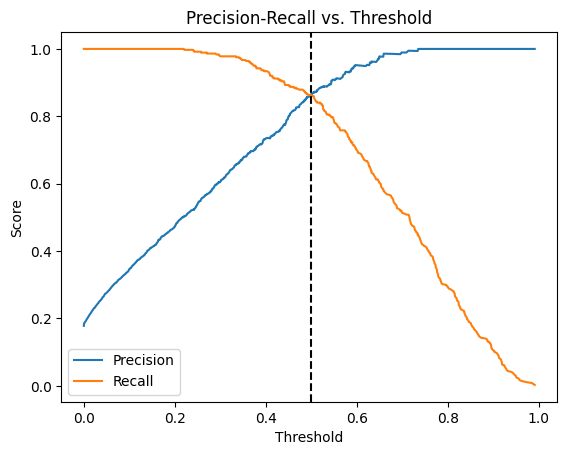

In [42]:
# Precision-Recall vs. Threshold plot for Random Forest classifier
precision, recall, thresholds = pr_threshold(rfc, X_train)

As the threshold increase, precision increases while recall decreases. In addition, increasing the threshold seems to result in more decrease in recall than increase in precision, and vice versa when lowering the threshold. It makes sense that a threshold of 0.5 is where the precision and recall seem the most balanced, since we using the F1 score to find the best estimators.

Let's see what recall we get when we lower the precision to 0.8 and to 0.75.

In [43]:
# Get the index for the lowest precision value above 0.8
# and print the respective threshold, recall, and precision values
precision_80_idx = (precision >= 0.8).argmax()
threshold_80 = thresholds[precision_80_idx]
print("Threshold =", threshold_80)
print("Recall =", recall[precision_80_idx])
print("Precision = ", precision[precision_80_idx])
print()

# Same as above for precision above 0.75
precision_75_idx = (precision >= 0.75).argmax()
threshold_75 = thresholds[precision_75_idx]
print("Threshold =", threshold_75)
print("Recall =", recall[precision_75_idx])
print("Precision = ", precision[precision_75_idx])

Threshold = 0.4500689647200879
Recall = 0.8928571428571429
Precision =  0.8004926108374384

Threshold = 0.4218290958329184
Recall = 0.9120879120879121
Precision =  0.751131221719457


By decreasing precision to 0.8 by lowering the threshold to 0.45, we get an increase of 0.03 in recall at the cost of 0.06 in precision. This trade-off may or may not be worth it, but I think the drop in precision is too steep for recall to not even break 0.9. It also doesn't seem to be worth lowering the precision lower to bring recall up to 0.9. Therefore, I will keep the original model with the default threshold of 0.5 as my preferred Random Forest Classifier.

### Gradient Boosting with XGBoost

Next, we will build a model using the XGBoost gradient boosting method. The reason why I chose it above other boosting methods such as AdaBoost or sklearn's GradientBoostingClassifier is that XGBoost provides for options for regularization that can help with imbalanced data.

I will also control the class weights by setting the scale_pos_weight parameter to the recommended value for the ratio of the number of negative to positive instances (ratio of False to True).

In [44]:
from xgboost import XGBClassifier

# Set the scale weight to the ratio of False to True instances of the target
scale_pos_weight = (y_train == False).sum() / (y_train == True).sum()

# XGBoost classifier
xgb_clf = XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight, random_state=0)

param_grid = {
    'max_depth': [2, 3, 4],
    'min_child_weight': [6, 7, 8],
    'learning_rate': [0.4, 0.5, 0.6],
    'lambda': [0.09, 0.1, 0.11],
    'alpha': [0.04, 0.05, 0.06]
}

xgb_grid_search = GridSearchCV(xgb_clf, param_grid, cv=cv, scoring='f1')
xgb_grid_search.fit(X_train, y_train)

print("XGBoost")
print("Best parameters:", xgb_grid_search.best_params_)
print("Best score:", xgb_grid_search.best_score_)

xgb = xgb_grid_search.best_estimator_
print_scores(xgb, X_train)

XGBoost
Best parameters: {'alpha': 0.05, 'lambda': 0.1, 'learning_rate': 0.5, 'max_depth': 2, 'min_child_weight': 7}
Best score: 0.9339363537869566
                           Recall  Precision        F1       AUC
Training Set Scores:      1.00000   0.970667  0.985115  0.999998
Cross-Validation Scores:  0.96978   0.900510  0.933862  0.996731


The cross-validation scores are looking quite good when compared to the results for Random Forests. In particular, precision and especially recall go up significantly (and consequently F1 also increases), and AUC also slightly increases. There might still be some overfitting going on, but the XGBoost model seems to generalize better than the Random Forest model.

Let's look at the feature importances. Note that because of the L1 and L2 regularization from choosing alpha and lambda respectively, the model already performs feature selection, so we don't need to try to build a reduced model by manually removing the less important features.

In [45]:
# List the feature importances from the XGBoost classifier
importances = []
for score, name in zip(xgb.feature_importances_, X_train.columns):
    importances.append((round(score, 2), name))
importances = sorted(importances, reverse=True)
for score, name in importances:
    print(score, name)

0.23 Age
0.14 Have you ever had suicidal thoughts ?
0.1 Pressure
0.08 Student
0.07 Satisfaction
0.07 Financial Stress
0.06 Work/Study Hours
0.06 Sleep Duration_Less than 5 hours
0.06 Dietary Habits_Unhealthy
0.04 Family History of Mental Illness
0.04 Dietary Habits_Healthy
0.02 Sleep Duration_More than 8 hours
0.02 Sleep Duration_7-8 hours
0.01 Female
0.0 Only Class 12 Degree
0.0 City_Vasai-Virar
0.0 City_Srinagar
0.0 City_Pune
0.0 City_Lucknow
0.0 City_Kalyan
0.0 City_Hyderabad
0.0 City_Bhopal


We see that Age is still the most important but its weight is significantly less than for the Random Forests classifier. A number of the others features also increased or decreased a non-negligible amount in importance.In particular, Have you ever had suicidal thoughts ? was given more importance, Family History of Mental Illness, Dietary Habits, and Sleep Duration were given slightly more importance. Only Class 12 Degree dropped to an importance of 0.1. Female and the City features remained with very low importances.

Now, let's plot the precision and recall against threshold.

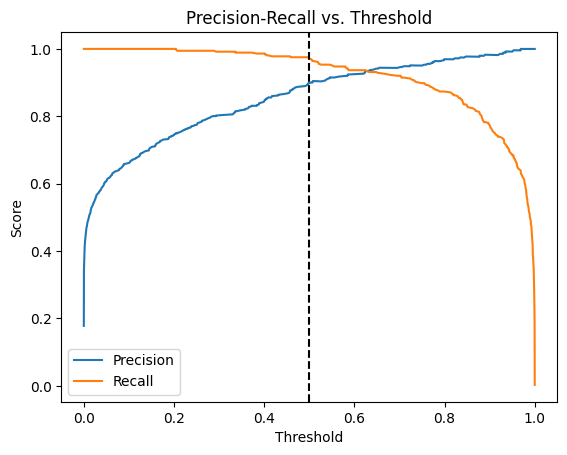

In [46]:
# Precision-Recall plot for XGBoost classifier
precision, recall, thresholds = pr_threshold(xgb, X_train)

Unlike with the Random Forests Classifier, the two curves intersect further to the right. At the default 0.5 threshold, recall is already high so we might not want to needlessly lower the precision. Precision is also near 0.9 which is very good. If we'd like more precision, we could move to where the intersection takes place as the cost of a small cost in recall, but I think the default threshold is satisfactory. However, out of curiosity we'll look at the threshold where recall and precision are equal.

In [47]:
# Find the threshold with the smallest difference in precision and recall
pr_diff = np.abs(precision - recall)
th_idx = pr_diff.argmin()
th = thresholds[th_idx]
recall_th = recall[th_idx]
precision_th = precision[th_idx]
f1_th = 2 * (precision_th * recall_th) / (precision_th + recall_th) # F1 score using threshold th

# Print the recall, precision, and F1 scores for threshold th
df = pd.DataFrame([{'Recall': recall_th, 'Precision': precision_th, 'F1': f1_th}])
df.index = [f"Threshold = {th}"]
print(df)
print()

# Print the scores for the default threshold 0.5 for comparison
print("Threshold = 0.5")
print_scores(xgb, X_train)

                                  Recall  Precision        F1
Threshold = 0.6283968687057495  0.934066   0.934066  0.934066

Threshold = 0.5
                           Recall  Precision        F1       AUC
Training Set Scores:      1.00000   0.970667  0.985115  0.999998
Cross-Validation Scores:  0.96978   0.900510  0.933862  0.996731


Using a threshold of about 0.628, we get a 0.034 increase in precision in return for a 0.035 decrease in recall for the cross-validation scores. This is a fair trade-off that we can definitely consider. We could also consider threshold values between 0.5 and 0.628. However as established earlier, we would like to priorize recall, and the default threshold of 0.5 seems to give the best recall without sacrificing the precision too much. So, we'll just go with the default threshold again.

### Support Vector Machine (SVM)

Finally, we will build a Support Vector Machine Classifier. Compared to the other two methods, SVMs are more sensitive to imbalance and multicollinearity, but we can help mitigate the effects by selecting the hyperparameters such as setting class weights to balanced, choosing a non-linear kernel, and tuning the regularization parameter C. Furthermore, SVMs are sensitive to scaling of the data, so we will use the scaled train and data sets that we prepared beforehand.

We'll build two different models using the linear and rbf kernels respectively. We will also build models with reduced feature sets by removing features with low correlation to the target.

In [48]:
from sklearn.svm import SVC

def grid_search_stats(svm_grid_search, X_train_scaled=X_train_scaled):
    svm = svm_grid_search.best_estimator_
    print("Best parameters: ", svm_grid_search.best_params_)
    print("Best score:", svm_grid_search.best_score_)
    print_scores(svm, X_train_scaled)

In [49]:
# SVM with Linear Kernel

param_grid = {
    'C': [9.1, 9.15, 9.2, 9.25],
    'gamma': ['scale', 'auto']
}

svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0)

svm_lin_grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1')
svm_lin_grid_search.fit(X_train_scaled, y_train)

print("SVM with Linear kernel")
grid_search_stats(svm_lin_grid_search)

SVM with Linear kernel
Best parameters:  {'C': 9.15, 'gamma': 'scale'}
Best score: 0.9598316719135731
                            Recall  Precision        F1       AUC
Training Set Scores:      1.000000   0.947917  0.973262  0.999563
Cross-Validation Scores:  0.980769   0.939474  0.959677  0.998984


In [50]:
# SVM with RBF Kernel

param_grid = {
    'C': [49, 50, 51, 52, 53],
    'gamma': [0.009, 0.01, 0.011]
}

svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=0)

svm_rbf_grid_search = GridSearchCV(svm, param_grid, cv=cv, scoring='f1')
svm_rbf_grid_search.fit(X_train_scaled, y_train)

print("SVM with RBF kernel")
grid_search_stats(svm_rbf_grid_search)

SVM with RBF kernel
Best parameters:  {'C': 51, 'gamma': 0.01}
Best score: 0.949525838294311
                            Recall  Precision        F1      AUC
Training Set Scores:      1.000000   0.994536  0.997260  1.00000
Cross-Validation Scores:  0.956044   0.943089  0.949523  0.99747


SVMs seem to perform better than the previous models. Surprisingly, the linear kernel is performing a lot better on the cross-validation scores compared to rbf. In particular, the differences in training set and cross-validation for the linear kernel are small, while the differences are larger for the rbf kernel. The rbf kernel introduces more complexity to the model, which could explain why there seems to be overfitting. 

Now, let's see if removing features may improve performance. Let's keep all the features with correlation coefficients with the target that are above 0.1. These happen to be exactly the top 8 most important features from our Random Forest model, so we can just reuse and create scaled copies of the reduced training and test sets.

In [51]:
# Create scaled versions of the X_train_red and X_test_red sets
scaler_red = StandardScaler()
X_train_scaled_red = scaler_red.fit_transform(X_train_red)
X_test_scaled_red = scaler_red.transform(X_test_red)

In [52]:
# Reduced Model with Linear Kernel

param_grid = {
    'C': [5, 5.1, 5.2, 5.3, 5.4, 5.5],
    'gamma': ['scale']
}

svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=0)

svm_lin_grid_search_red = GridSearchCV(svm, param_grid, cv=cv, scoring='f1')
svm_lin_grid_search_red.fit(X_train_scaled_red, y_train)

print("Linear kernel (Reduced)")
grid_search_stats(svm_lin_grid_search_red, X_train_scaled_red)

Linear kernel (Reduced)
Best parameters:  {'C': 5.4, 'gamma': 'scale'}
Best score: 0.8584871798988092
                            Recall  Precision        F1       AUC
Training Set Scores:      0.953297   0.794050  0.866417  0.992534
Cross-Validation Scores:  0.947802   0.784091  0.858209  0.991091


In [53]:
# Reduced Model with RBF Kernel

param_grid = {
    'C': [100, 101, 102, 103, 104],
    'gamma': [0.009, 0.01, 0.011]
}

svm = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=0)

svm_rbf_grid_search_red = GridSearchCV(svm, param_grid, cv=cv, scoring='f1')
svm_rbf_grid_search_red.fit(X_train_scaled_red, y_train)

print("RBF kernel (Reduced)")
grid_search_stats(svm_rbf_grid_search_red, X_train_scaled_red)

RBF kernel (Reduced)
Best parameters:  {'C': 102, 'gamma': 0.01}
Best score: 0.86156205162839
                            Recall  Precision        F1       AUC
Training Set Scores:      0.978022   0.807256  0.884472  0.994537
Cross-Validation Scores:  0.942308   0.793981  0.861809  0.990399


Removing features resulted in worse results for both linear and rbf models. We got excellent results with with keeping all the features, and the linear kernel gives better results than the rbf kernel, but we'll keep both models for comparison.

In [54]:
# Save the best estimators for SVM with linear and rbf kernels
svm_lin = svm_lin_grid_search.best_estimator_
svm_rbf = svm_rbf_grid_search.best_estimator_

## Model Evaluation and Comparison

Finally, we now have four final models using the Random Forests, XGBoost (Gradient Boosting), and SVM (with linear and rbf kernels) methods. We will evaluate them using the four metrics of precision, recall, f1, and auc, look at their confusion matrices, as well as representing these metrics visually through precision_recall curves and ROC curves.

In [55]:
# Get predictions and prediction probabilities for each of the four classifiers
labels = ['Random Forests', 'XGBoost', 'SVM (Linear)', 'SVM (RBF)']
y_preds = [rfc.predict(X_test), xgb.predict(X_test), svm_lin.predict(X_test_scaled), svm_rbf.predict(X_test_scaled)]
y_probs = [rfc.predict_proba(X_test)[:, 1], xgb.predict_proba(X_test)[:, 1], svm_lin.predict_proba(X_test_scaled)[:, 1], svm_rbf.predict_proba(X_test_scaled)[:, 1]]
scores = []

# For each classifier, append its recall, precision, f1, and auc scores to the list of scores
for y_pred, y_prob in zip(y_preds, y_probs):
    scores_clf = {}
    scores_clf['Recall'] = recall_score(y_test, y_pred)
    scores_clf['Precision'] = precision_score(y_test, y_pred)
    scores_clf['F1'] = f1_score(y_test, y_pred)
    scores_clf['AUC'] = roc_auc_score(y_test, y_prob)
    scores.append(scores_clf)

df = pd.DataFrame(scores)
df.index = labels
print(df)

                  Recall  Precision        F1       AUC
Random Forests  0.857143   0.896552  0.876404  0.991595
XGBoost         0.967033   0.888889  0.926316  0.995249
SVM (Linear)    0.989011   0.918367  0.952381  0.998852
SVM (RBF)       0.934066   0.904255  0.918919  0.997077


#### Comparison of Scores

We see that SVM with linear kernel performs the best across all four metrics. Random Forests have significantly worse recall, which isn't good. While the Random Forests classifier have slightly better precision than the XGBoost classifier, along with the SVM classifier's precision the values don't differ much to be significant.

The AUC values are very high for all models, with linear SVM having the highest score.

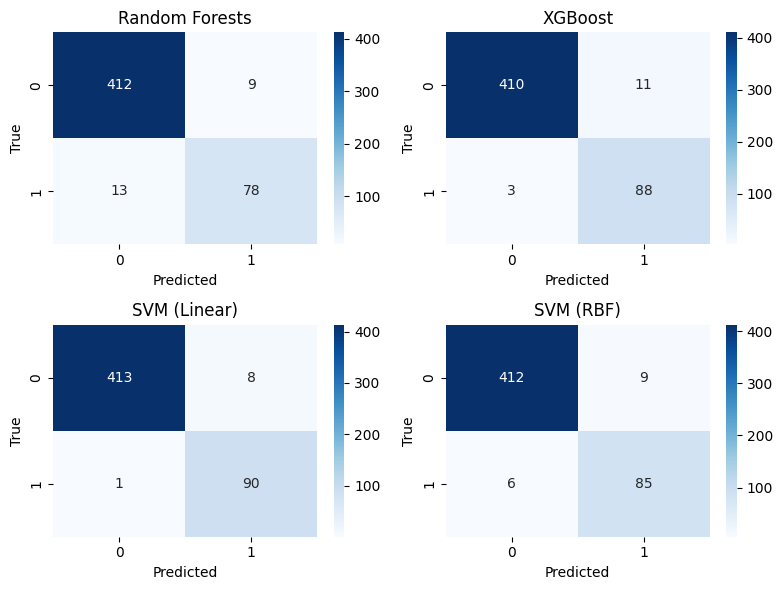

In [56]:
from sklearn.metrics import confusion_matrix

# Display heatmaps of the confusion matrix for each classifier
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()
for y_pred, title, ax in zip(y_preds, labels, axes):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)
plt.tight_layout()
plt.show()

#### Confusion Matrices

We see that all four models have about the same amount of True Negatives. They also made around the same number of False Positives. Linear SVM had the most True Negatives and least True Positives, while XGBoost had the least True Negative and most False Positives. However, these counts only differed by 3 instances.

Random Forests had significantly less True Positives and more False Negatives than the other two. Again, linear SVMs did the best with these two counts. In comparison, Random Forests differed by a count of 12.

It seems that Random Forests leans more towards predicting the majority False class, while XGBoost leans comparatively a bit more towards predicting the minority True class, with radial SVM being in between. Yet, these three made more misclassifications than linear SVM.

Linear SVM is again the overall winner here.

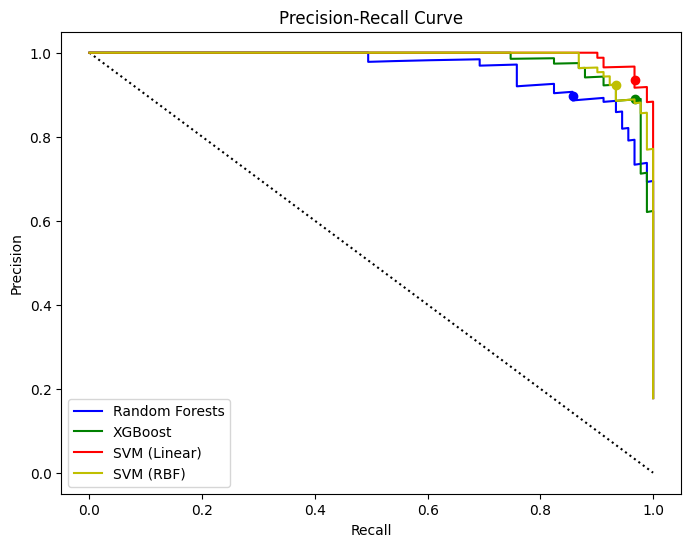

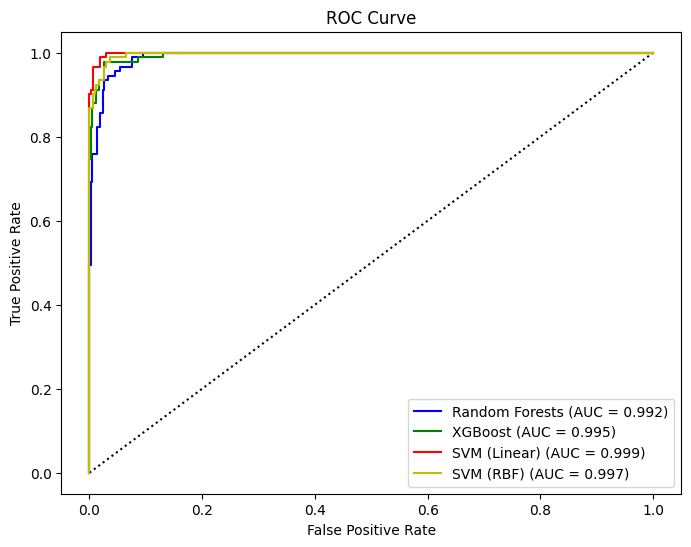

In [57]:
from sklearn.metrics import roc_curve, auc

colors = ['b', 'g', 'r', 'y']

# Plot precision and recall curves, and points on the curves corresponding to threshold = 0.5
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [1, 0], 'k:')

for y_prob, label, color in zip(y_probs, labels, colors):
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, color=color, label=label)
    idx = np.argmax(thresholds >= 0.5)
    plt.plot(recall[idx], precision[idx], 'o', color=color)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k:')

for y_prob, label, color in zip(y_probs, labels, colors):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f"{label} (AUC = {roc_auc:.3f})")
        
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

#### ROC curves

Once again, it looks like linear SVM is the clear winner while Random Forests performs the worst of the three, with XGBoost in the middle. Radial SVM does slightly better than XGBoost based on this metric.

Looking at the Precision-Recall curve, it looks like we could've chosen a different threshold for the Random Forests Classifier that would increase recall to above 0.9 with little decrease in precision, but this is in hindsight and it still would've done worse compare to the other models.

We also see that all four models have very high AUC scores. While this may seem good, it could also indicate data leakage resulting in overfitting on the test data. However, most of my feature engineering was done after splitting the data set into the training and test sets, and any modifications to the features done before the split wouldn't have caused information from the test data to leak into the training data. Other possible explanations for the very high AUC scores is that the dataset itself has some issues or the problem itself has well-separated classes.

### Summary of Model Analysis

- To build each model, I used grid search cross-validation using the F1 score as the metric to get the best estimators from different combinations of hyperparameters.
- I also tried removing less important features and considered different thresholds, but ultimately didn't see the need to make these changes.
- I did not use accuracy as a metric for comparison due to the imbalance in the data set. Instead, I used precision, recall, F1 score (the harmonic mean of precision and recall), and AUC scores, as well as visual representations of using confusion matrices, precision-recall curves, and ROC curves to evaluate model performance.
- In the end, **the best performing model out of the ones I tried was clearly the Support Vector Machine classifier using a linear kernel**, beating out all the other models in every metric used.
- Meanwhile, the approach with the worst (yet still relatively good) performance was the Random Forests classifier.

## Discussion and Conclusion

After exploring the data, I found that the data was imbalanced at about a 1:4 True to False ratio for the target. In addition, there was some multicollinearity due to correlations between three of the features. These issues generally aren't a problem for tree-based methods such as Random Forests and XGBoost, compared to SVMs and regression, especially linear methods. So it came as a surprise that the linear SVM model was the best performing model (of the ones I trained) and furthermore had very excellent results, misclassifying less than 2% of the test set.

### Reasons for issues in model performance
When comparing metrics from the training set and cross-validation, I found that the Random Forests model seems to suffer the worst from overfitting. Overfitting is still existent but to a less extent with XGBoost. There seemed to be comparatively very little signs of overfitting with the SVM models, but the radial SVM seemed to overfit a bit more than the linear SVM. Therefore, it seems that the amount of overfitting is the main reason for the differences in performance.

The imbalance in the data is probably still ofa big cause overfitting, even after taking measures such as stratifying the data splits and adjusting class weights.  I fine-tuned the hyperparameters for each model, but I could try to further fine-tune some of the other hyperparameters that I didn't touch. However, rather than improving on the model building step, I believe it may be more effective to improve on feature engineering or even data gathering steps.

Linear SVM likely performs the best due to its simplicity. It's possible that the data itself may inherently lend itself better to this type of model, such as in the case of relatively clear decision boundaries that are more easily linearly-separable. Non-linear models may try to overcomplicate the decision boundaries, leading to overfitting and a lower ability to generalize on unseen data.

### Possible improvements
For this project, it wouldn't be viable for to gather more data for this particular data set. But if it were possible, gathering more data especially on depressed individual to create a more balanced data set would likely help deal with overfitting.

While I did reduce the number of features, there may have been better ways to deal with the categorical features with many different categories such as Degree, Profession, and City by combining similar categories rather than simply dropping many of them. In that case, I would likely want to consult a domain expert who may provide insight on how to deal with such features, which could result in new features that may prove more useful.

However, rather than trying improve on the lesser performing tree-based models, it may be better to focus on improving the one type of model that I know already works very well: the SVM models. I was able to achieve very high recall with the linear SVM, and precision was also very good. However, there is still room for improvement with precision. I only explored different options for the C and gamma hyperparameters for the linear and rbf kernels. There are many more options I could try. I could try other types of kernels such as polynomial or sigmoid, both of which have more hyperparameters that can be adjusted. I could also try specific class weights aside from the given 'balanced' mode.

I could also try regression techniques such as logistic, ridge, or lasso regression since they might work well for this specific dataset in the same way that SVM does.

### Final Thoughts
From both the correlation matrix from EDA as well as the feature importances from the Random Forests and XGBoost models, we found that age was the most important feature. Other features that are important seem to involve one's work/study life. This is followed by features of seemingly lesser importance involving lifestyle habits such as sleep and dietary habits. On the other hand, features such as gender and especially one's city seems to have very little correlation with depression. While this doesn't necessarily tell us what may *cause* depression, it may give us a good idea on what attributes may be characteristic of those suffering depression.

Our primary goal was to build a model capable of predicting depression in an individual, which I would say we were successful in doing using the linear SVM method. We also discussed ways in which we can possibly improve our model even further.